# NucleaSeq Analysis

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl

In [3]:
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

In [4]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

In [5]:
from freebarcodes import editmeasures

In [6]:
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

# Run Parameters

Again, this section will likely be the only one to require user input. The run parameters here should be copied exactly from the Full Data Analysis notebook. And define the color and linestyle options you would like for display.

In [7]:
run_label = 'Cas9_D'
tname = 'D'
read_name_by_sample_fpath = 'JA18412-100827729/Cas9_D_read_names_by_sample.txt'
exploded_oligos_fpath = 'exploded_target_d_seqs.txt'
targets_fpath = '/mnt/marble/hdd2/hawkjo/alignment_tmp/master_style/targets.yml'
pamtarg_pos = 24

In [8]:
sample_names = [
    'ControlDWE',
    'WTD0',
    'WTD12s',
    'WTD1',
    'WTD3',
    'WTD10',
    'WTD30',
    'WTD100',
    'WTD300',
    'WTD1000',
]

In [9]:
times = 60 * np.array([0, 0, 1, 3, 10, 30, 100, 300, 1000])
times[1] = 12

Display colors and linestyles are defined here for each side and cut site, as returned by the `color_and_linestyle` function. Cut sites must be included here to be displayed.

In [10]:
base_color_given_side = {
    'left': 1/255.0 * np.array([164, 31, 102]),
    'right': 1/255.0 * np.array([140, 110, 32])
}
    
def color_and_linestyle(side, site):
    white = np.ones((3,))
    base_color = base_color_given_side[side]
    color_and_ls_idx_given_site = {
        7: (0, 1),
        6: (0, 2),
        5: (1, 0),
        4: (1, 1),
        3: (1, 2),
        2: (2, 0),
        1: (2, 1),
    }
    color_spacing = np.linspace(0, 0.7, 3)[::-1]
    color_idx, ls_idx = color_and_ls_idx_given_site[site]
    color = base_color + color_spacing[color_idx] * (white - base_color)
    ls = [':', '--', '-'][ls_idx]
    return color, ls

# Load Expected Sequences

In [11]:
import random
import yaml
import editdistance
from collections import Counter, defaultdict
from general_sequence_tools import dna_rev_comp
from nucleaseq.OligosContainer import OligosContainer
from nucleaseq import processing, seqtools

In [12]:
targets = yaml.load(open('/mnt/marble/hdd2/hawkjo/alignment_tmp/master_style/targets.yml'))
perfect_target = targets[tname]
print 'Target {}:'.format(tname), perfect_target

Target D: TTTAGTGATAAGTGGAATGCCATGTGG


In [13]:
oligo_container = OligosContainer(exploded_oligos_fpath, perfect_target, pamtarg_pos)

2020-04-12 13:42:40   Loaded 8,684 oligos (8,684 unique)
2020-04-12 13:42:40   Oligo lengths: Counter({116: 8684})
2020-04-12 13:42:40   43 Perfect target oligos
2020-04-12 13:42:40   8,629 Target oligos
2020-04-12 13:42:40   55 Non-target oligos
2020-04-12 13:42:40   Left/Right Primer Seqs: AACCGCCGAATAACAGAGT / AAGAACGCCTCGCACACT
2020-04-12 13:42:40   Left/Right Primer Edit Distance: 10
2020-04-12 13:42:40   Target oligo left buffers: Counter({'CAGAT': 8618, 'CAGTT': 1, 'CAGCT': 1, 'CAGTC': 1, 'CAGAA': 1, 'CAGAC': 1, 'CAGAG': 1, 'CAGTG': 1, 'CAGTA': 1, 'CAGGA': 1, 'CAGCA': 1, 'CAGGT': 1})
2020-04-12 13:42:40   Target oligo right buffers: Counter({'TGATC': 8617, 'AAGAC': 1, 'GTGAC': 1, 'AGGAC': 1, 'TCGAC': 1, 'TTGAC': 1, 'TGGAC': 1, 'CAGAC': 1, 'ATGAC': 1, 'TAGAC': 1, 'GAGAC': 1, 'ACGAC': 1, 'CTGAC': 1})
2020-04-12 13:42:40   Most common left/right buffers: CAGAT / TGATC
2020-04-12 13:42:40   31 Perfect target and most common buffer oligos
2020-04-12 13:42:40   12 Alternate buffer oli

In [14]:
time_given_sample = {}
for tm, sn in zip(times, sample_names[1:]):
    time_given_sample[sn] = tm

# Load data

In [15]:
import pandas as pd
import re

In [16]:
cut_data = processing.load_and_concat_dfs('{}_cut_data_files'.format(run_label), 'cut_data')

2020-04-12 13:42:42   cut_data: 0-10,199,999  (102 files)
2020-04-12 13:42:42   Total missing: 0


In [17]:
print 'Total cut reads: {:,d}'.format(len(cut_data))

Total cut reads: 8,383,110


### cut_data schema

| read_name | sample_name | side | oriented_seq | seq_len | oligo | ref_rel_cut_pos | total_edits | pieces_edits ... | pieces_boundaries ... |
| - | - | - | - | - | - | - | - |

Where ref_rel_cut_pos is the position in the pam-defined coordinate system.

In [18]:
cut_data.describe()

,seq_len,cut_pamtarg_coord,total_edits,edits_primer_left,edits_barcode_left,edits_buffer_left,edits_target,edits_buffer_right,edits_right_buffer_buffer,edits_barcode_right,edits_primer_right,start_barcode_left,start_buffer_left,start_target,start_buffer_right,start_right_buffer_buffer,start_barcode_right,start_primer_right
count,8.383110e+06,8.383110e+06,327984.000000,4.289549e+06,4.303663e+06,4.303789e+06,8.375044e+06,4.436112e+06,4.435814e+06,4.431889e+06,4.421545e+06,4.303663e+06,4.303789e+06,8.375044e+06,4.436112e+06,4.435814e+06,4.431889e+06,4.421545e+06
mean,6.042539e+01,-3.271220e+00,5.900398,1.526860e-01,2.024252e-01,4.547900e-02,1.631646e-01,7.016595e-02,1.013464e-01,2.564256e-01,1.565141e-01,1.885220e+01,3.573761e+01,2.091640e+01,1.176416e+01,1.669345e+01,2.369757e+01,4.042839e+01
std,1.162122e+01,1.123118e+01,8.484742,9.522105e-01,7.766464e-01,2.883922e-01,9.196955e-01,3.104584e-01,4.054020e-01,7.129881e-01,7.371328e-01,1.578326e+00,2.209150e+00,2.041454e+01,1.633105e+01,1.627227e+01,1.618043e+01,1.595005e+01
min,3.000000e+01,-7.200000e+01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.200000e+01
25%,5.400000e+01,-4.000000e+00,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.900000e+01,3.600000e+01,0.000000e+00,7.000000e+00,1.200000e+01,1.800000e+01,3.500000e+01
50%,6.100000e+01,-3.000000e+00,4.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.900000e+01,3.600000e+01,3.900000e+01,7.000000e+00,1.200000e+01,1.900000e+01,3.600000e+01
75%,6.300000e+01,-3.000000e+00,8.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.900000e+01,3.600000e+01,4.100000e+01,7.000000e+00,1.200000e+01,2.000000e+01,3.700000e+01
max,1.520000e+02,1.160000e+02,126.000000,7.500000e+01,5.700000e+01,5.600000e+01,6.400000e+01,5.100000e+01,3.800000e+01,5.300000e+01,6.600000e+01,9.200000e+01,1.060000e+02,1.060000e+02,1.300000e+02,1.350000e+02,1.410000e+02,1.490000e+02


## All data

Lots of sanity check plots. These will hopefully not be very interesting, but can be useful for troubleshooting.

In [19]:
def display_pos_given_abs(pos):
    pos -= pamtarg_pos
    if pamtarg_pos > len(perfect_target) / 2:
        pos += 1
        pos = -pos
    if pos >= 0:
        pos += 1
    return pos

def display_pos_given_pamtarg(pos):
    if pamtarg_pos > len(perfect_target) / 2:
        pos = -pos
    return pos

def abs_pos_given_display(pos):
    if pos >= 0:
        pos -=1
    if pamtarg_pos > len(perfect_target) / 2:
        pos = -pos
        pos -= 1
    pos += pamtarg_pos
    return pos

def label_from_display_pos(pos):
    if pamtarg_pos < len(perfect_target) / 2:
        label_pos = pos
        other_pos = pos - 1
    else:
        label_pos = pos
        other_pos = pos + 1
    return '{}-{}'.format(other_pos, label_pos)

In [20]:
df = cut_data
side_df = {side: df[df.side == side] for side in ['left', 'right']}
edit_cols = [col for col in df.columns if col.startswith('edit')]
protected_cols = ['edits_target', 'edits_buffer_left', 'edits_buffer_right']
other_edit_cols = [col for col in edit_cols if col not in protected_cols]

/mnt/marble/hdd2/hawkjo/barcode_and_nucleaseq/src/nucleaseq/envnucleaseq/local/lib/python2.7/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


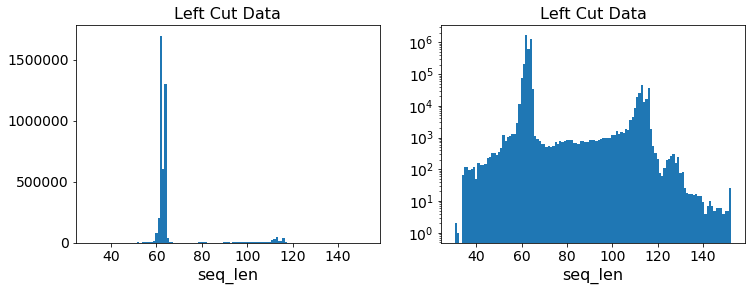

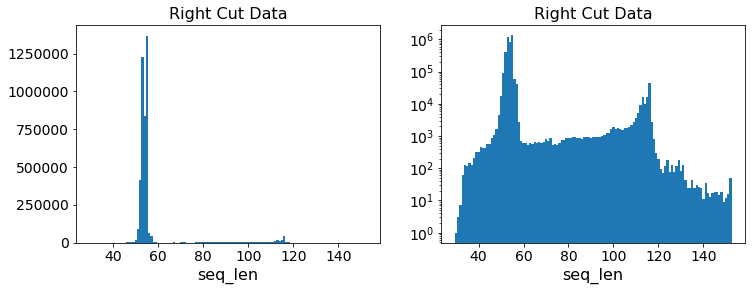

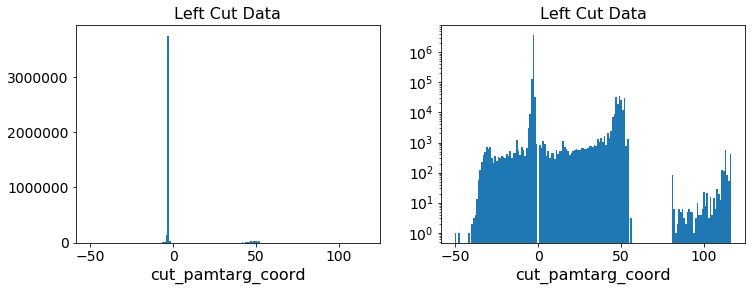

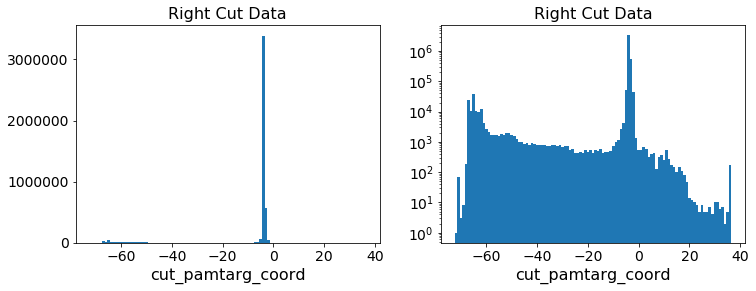

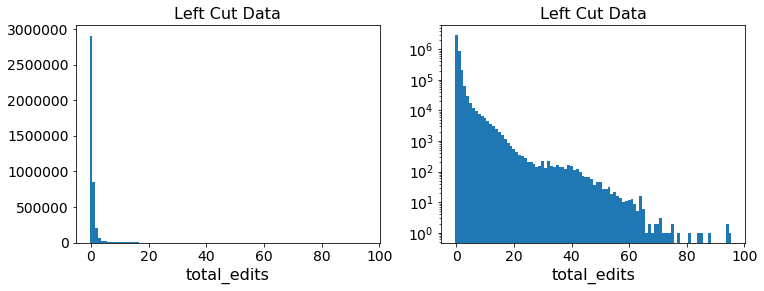

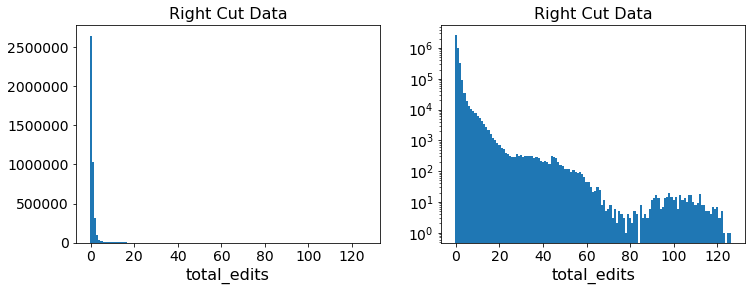

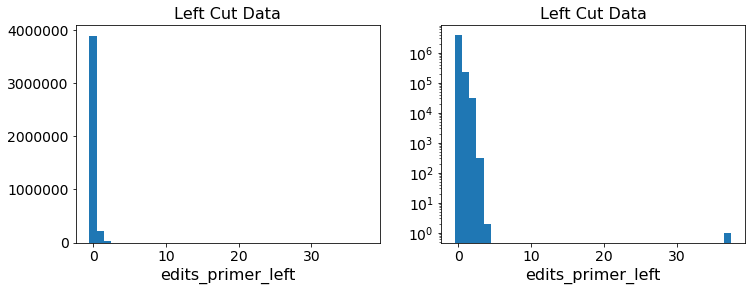

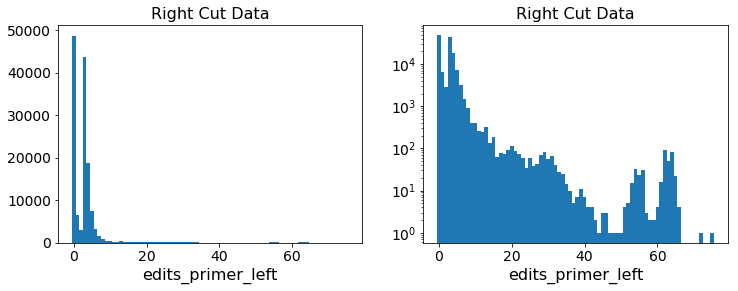

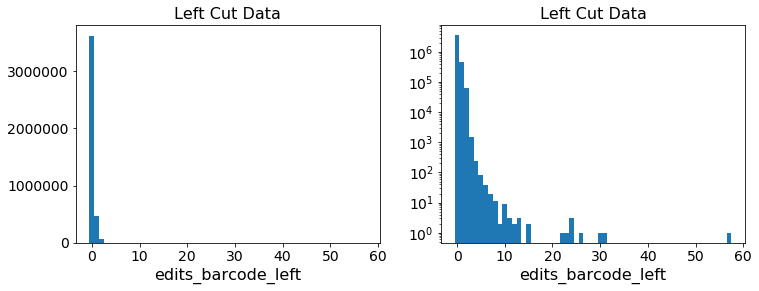

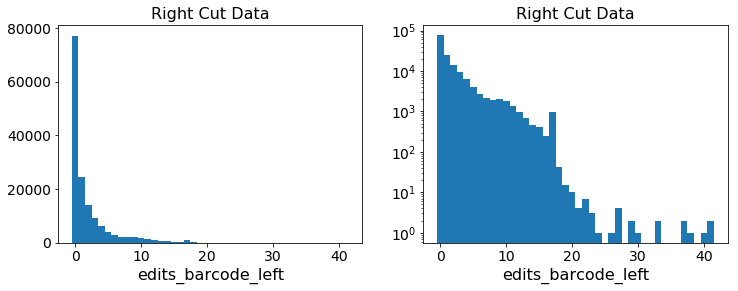

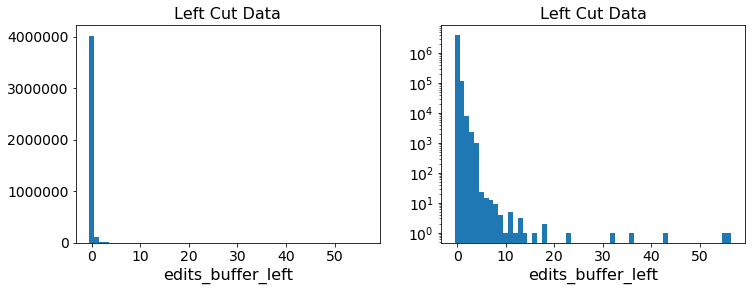

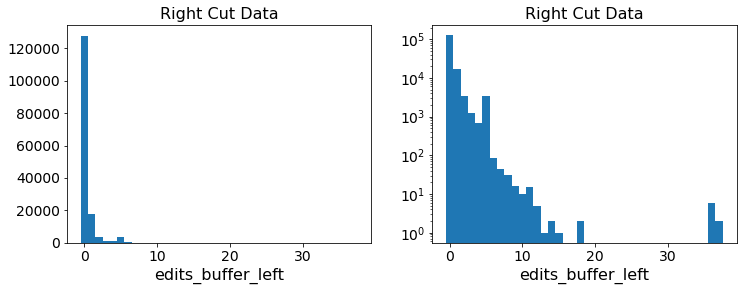

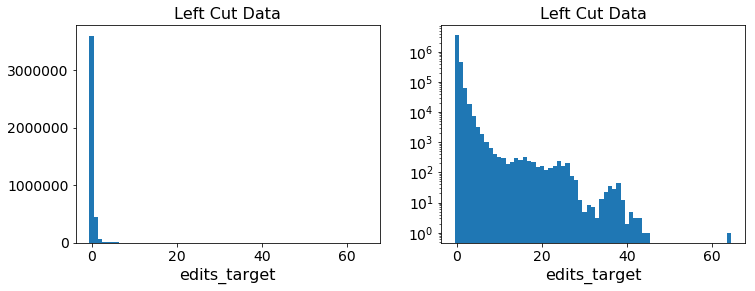

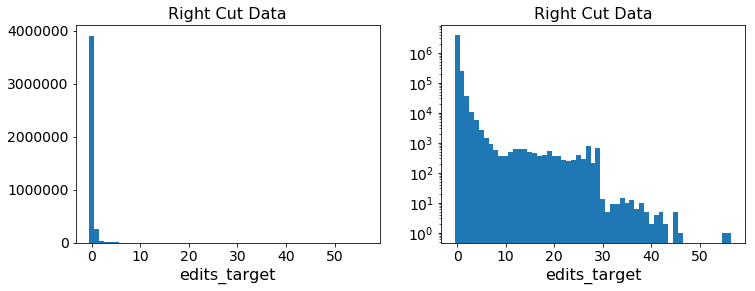

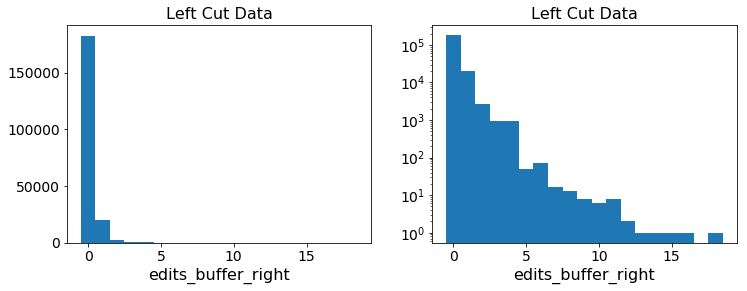

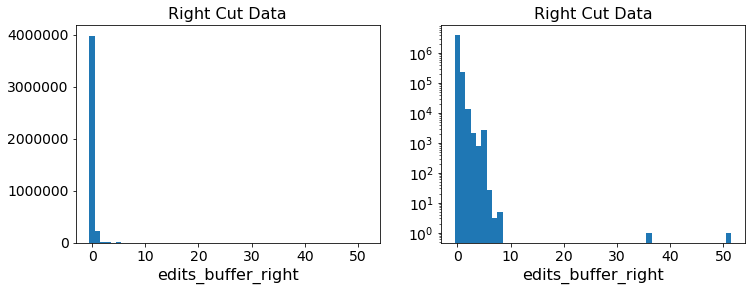

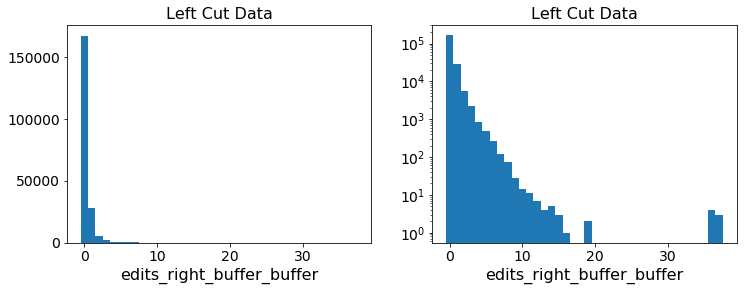

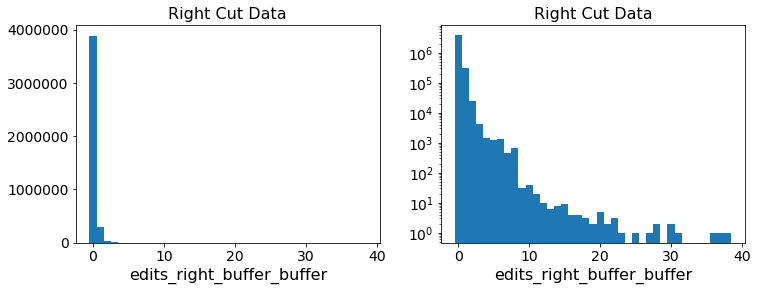

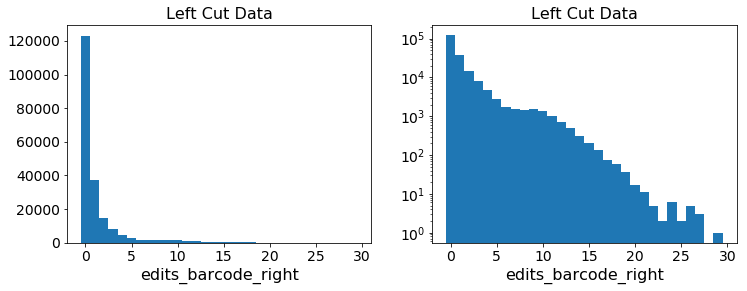

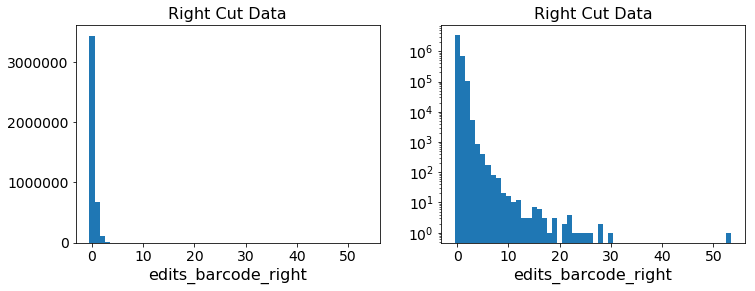

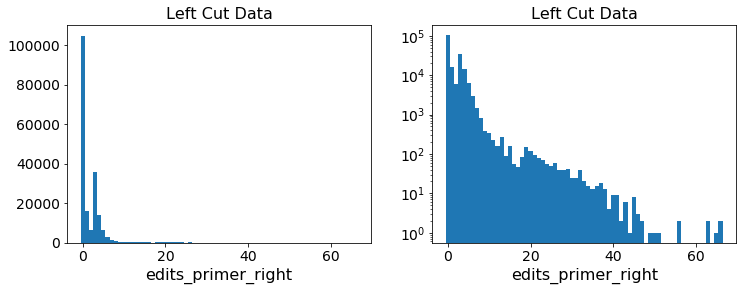

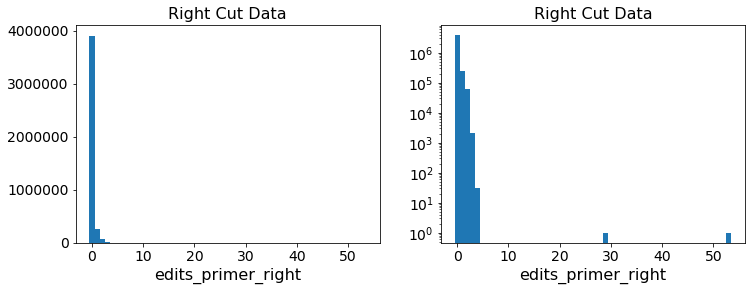

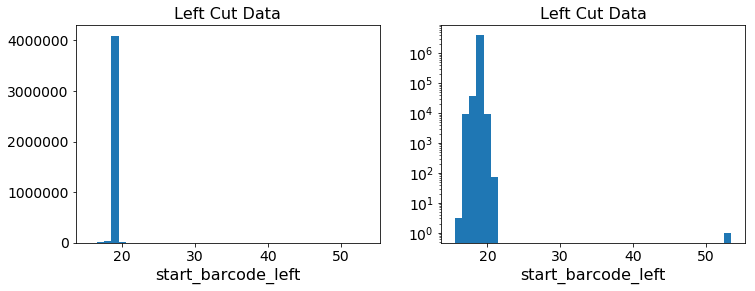

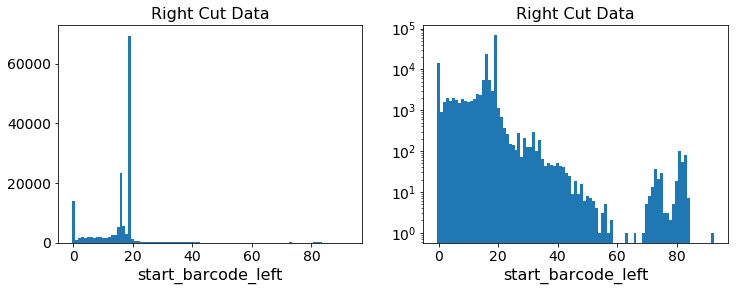

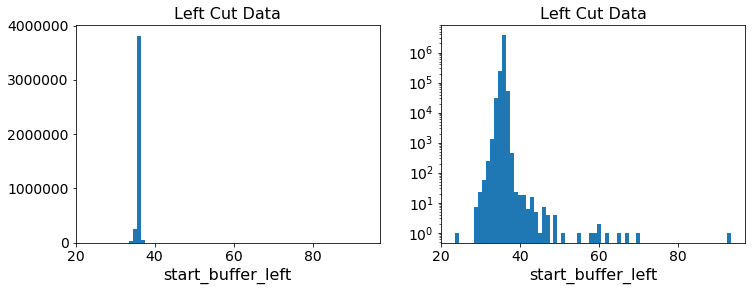

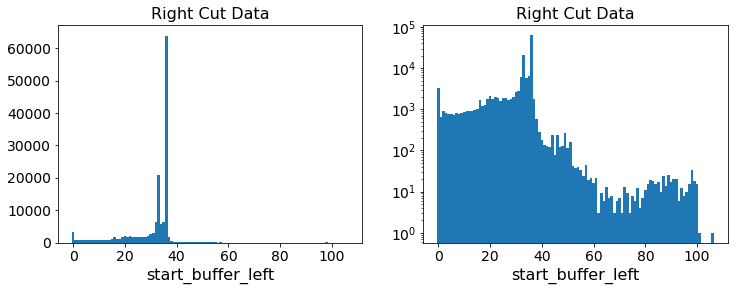

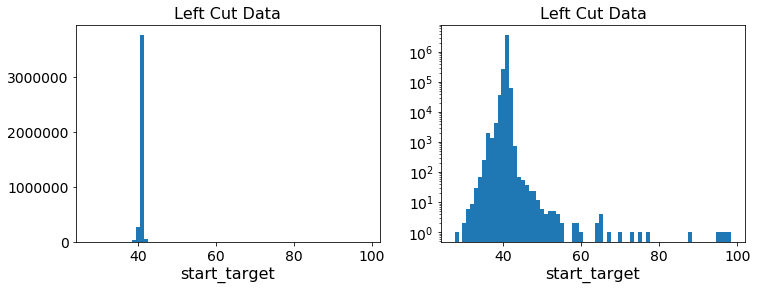

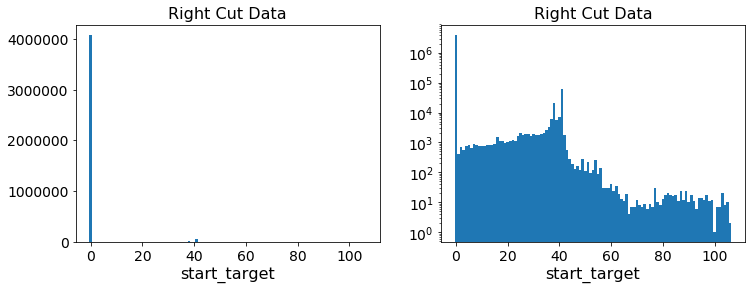

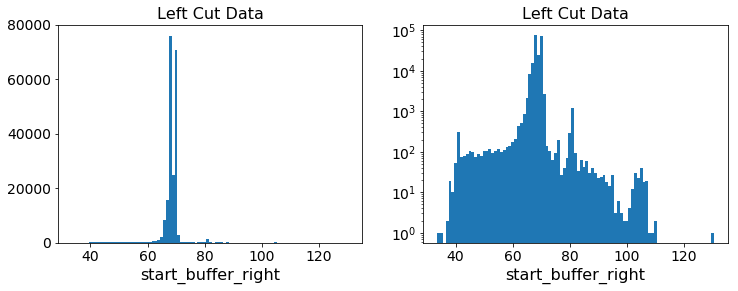

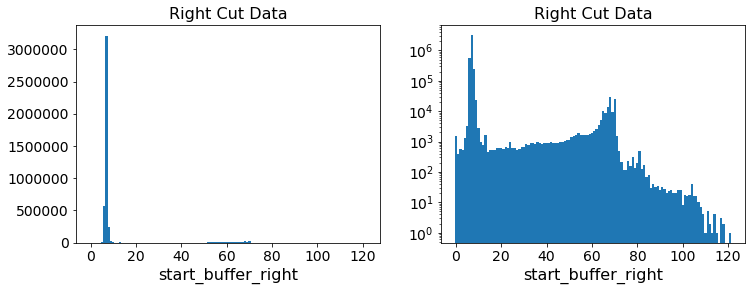

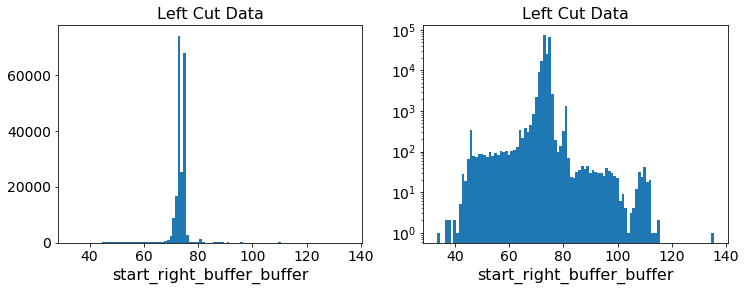

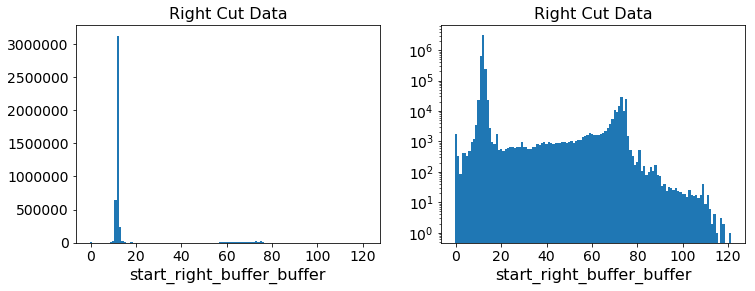

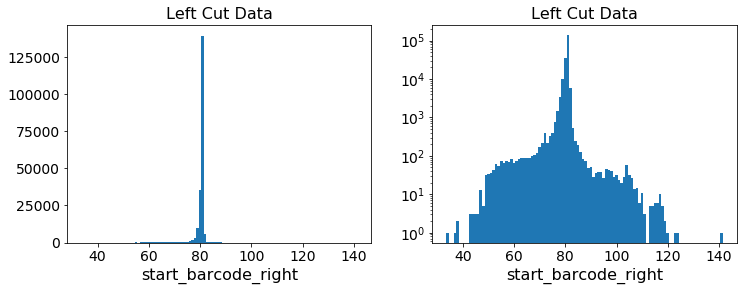

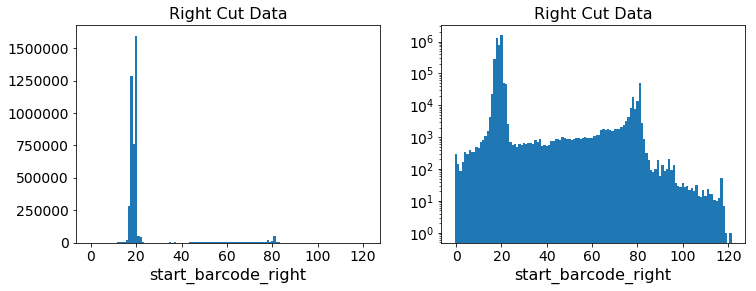

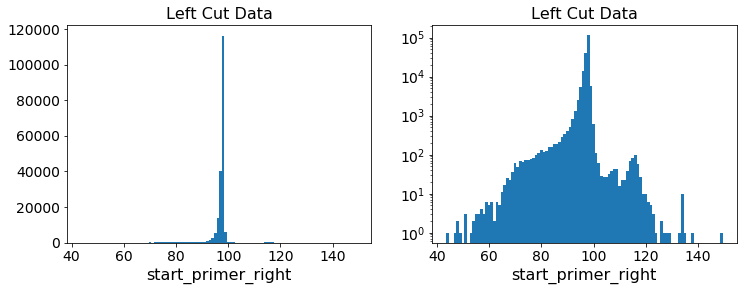

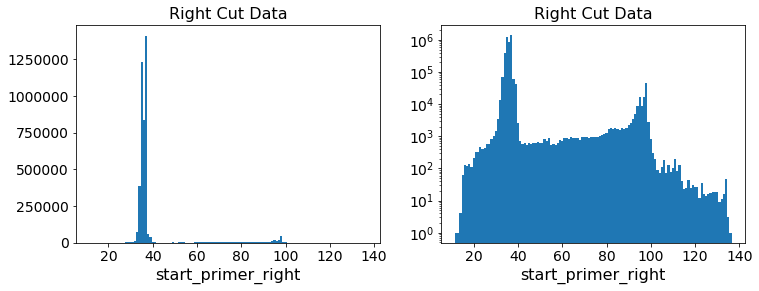

In [21]:
for label in df.columns:
    for side in ['left', 'right']:
        df = side_df[side]
        title = '{} Cut Data'.format(side.capitalize())
        if label in ['read_name', 'sample', 'oriented_seq', 'oligo', 'side'] or 'aligned' in label:
            continue
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        ax = axes[0]
        if label == 'total_edits':
            data = df[edit_cols].sum(axis=1)
        else:
            new_df = df[np.isfinite(df[label])]
            data = new_df[label]
        bins = np.arange(min(data), max(data) + 2) - 0.5
        ax.hist(data, bins)
        ax.set_xlabel(label)
        ax.set_title(title)
        ax = axes[1]
        ax.hist(data, bins)
        ax.set_xlabel(label)
        ax.set_yscale('log')
        ax.set_title(title)

In [22]:
label = 'seq_len'
sided_data = []
for side in ['left', 'right']:
    df = side_df[side]
    new_df = df[np.isfinite(df[label])]
    sided_data.append(list(new_df[label]))

with open('{}_cut_seq_lens.txt'.format(run_label), 'w') as out:
    out.write('[')
    out.write(',\n'.join(['[{}]'.format(', '.join(map(str, data))) for data in sided_data]))
    out.write(']')

In [23]:
label = 'seq_len'
sided_data = []
for side in ['left', 'right']:
    df = side_df[side]
    new_df = df[np.isfinite(df[label])]
    new_df = new_df[new_df['sample'] == sample_names[-1]]
    sided_data.append(list(new_df[label]))

with open('{}_cut_seq_lens_last_time.txt'.format(run_label), 'w') as out:
    out.write('[')
    out.write(',\n'.join(['[{}]'.format(', '.join(map(str, data))) for data in sided_data]))
    out.write(']')

## Cleaned Data

The data are filtered in a few ways:

* Zero observed errors in the target and buffer sequence
* A maximum of 1 error in any segment of the oligo
* Good total sequence length
* Remove outlier cut positions

By default, the last step is performed by accepting only the top 99% of all sequences centered around the largest bin.

Afterwards, we again have lots of sanity check plots for troubleshooting.

In [24]:
if not os.path.exists('figs'):
    os.mkdir('figs')

In [25]:
def tukey_clean(df, label):
    qs = df[label].quantile([0.25, 0.75])
    iqr = qs[0.75] - qs[0.25]
    tukey_min = qs[0.25] - 1.5 * iqr
    tukey_max = qs[0.75] + 1.5 * iqr
    df = df[df[label] >= tukey_min]
    df = df[df[label] <= tukey_max]
    return df

def capture_frac_clean(df, label, frac):
    vc = df[label].value_counts()
    thresh = vc.sum() * frac
    lb, ub, mode = vc.idxmax(), vc.idxmax(), vc.idxmax()
    vc = Counter(dict(vc))
    total = vc[lb]
    while total < thresh and abs(ub - mode) < 20 and abs(lb - mode) < 20:
        if vc[ub + 1] > vc[lb - 1]:
            ub += 1
            total += vc[ub]
        else:
            lb -= 1
            total += vc[lb]
    df = df[df[label] >= lb]
    df = df[df[label] <= ub]
    return df

In [26]:
cleaned_dfs = {}
for side in ['left', 'right']:
    df = side_df[side]
    print '{} {:30s}: {:15,d}'.format(side, 'Raw', len(df))
        
    # Remove seqs with edits in target or buffers
    for label in protected_cols:
        df = df[(df[label] == 0) | (df[label].isnull())]
    print '{} {:30s}: {:15,d}'.format(side, 'Zero target/buffer errors', len(df))            
        
    # Remove seqs with more than 1 edit anywhere else
    for label in other_edit_cols:
        df = df[(df[label] <= 1) | (df[label].isnull())]
    print '{} {:30s}: {:15,d}'.format(side, 'Max 1 error per segment', len(df))
            
    # Remove length and cut pos outliers
    #df = tukey_clean(df, 'seq_len')
    #df = tukey_clean(df, 'cut_pamtarg_coord')
    df = capture_frac_clean(df, 'seq_len', 0.99)
    print '{} {:30s}: {:15,d}'.format(side, 'Clean by seq_len', len(df))

    df = capture_frac_clean(df, 'cut_pamtarg_coord', 0.99)
    print '{} {:30s}: {:15,d}'.format(side, 'Clean by cut pos', len(df))
        
    cleaned_dfs[side] = df
    print

left Raw                           :       4,152,620
left Zero target/buffer errors     :       3,498,761
left Max 1 error per segment       :       3,416,322
left Clean by seq_len              :       3,329,099
left Clean by cut pos              :       3,307,752

right Raw                           :       4,230,490
right Zero target/buffer errors     :       3,697,177
right Max 1 error per segment       :       3,522,326
right Clean by seq_len              :       3,480,771
right Clean by cut pos              :       3,466,485



With default settings, there should be several missing plots in the cell below, corresponding to filtered data.

No data for Clean Right Data edits_primer_left
No data for Clean Right Data edits_barcode_left
No data for Clean Right Data edits_buffer_left
No data for Clean Left Data edits_buffer_right
No data for Clean Left Data edits_right_buffer_buffer
No data for Clean Left Data edits_barcode_right
No data for Clean Left Data edits_primer_right
No data for Clean Right Data start_barcode_left
No data for Clean Right Data start_buffer_left
No data for Clean Left Data start_buffer_right
No data for Clean Left Data start_right_buffer_buffer
No data for Clean Left Data start_barcode_right
No data for Clean Left Data start_primer_right


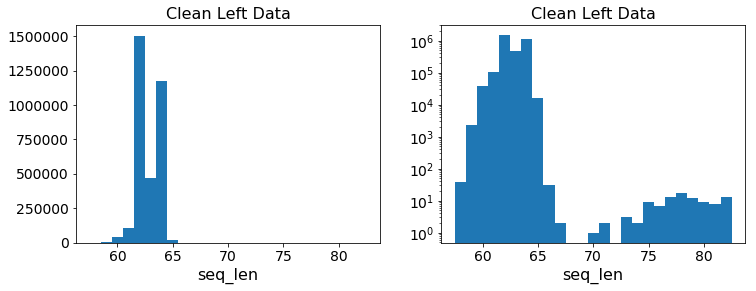

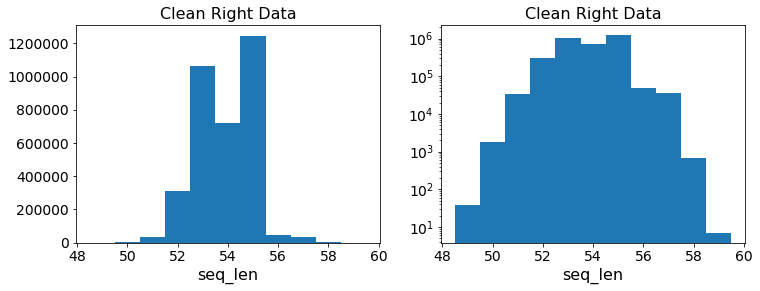

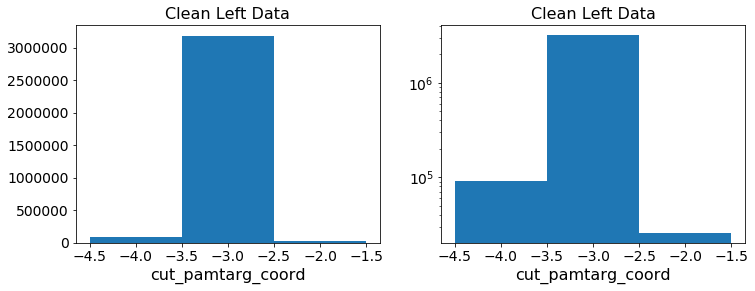

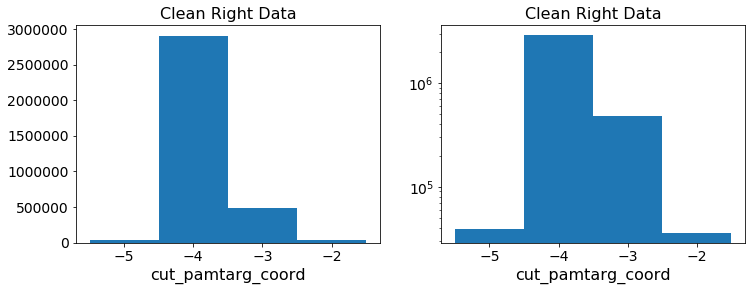

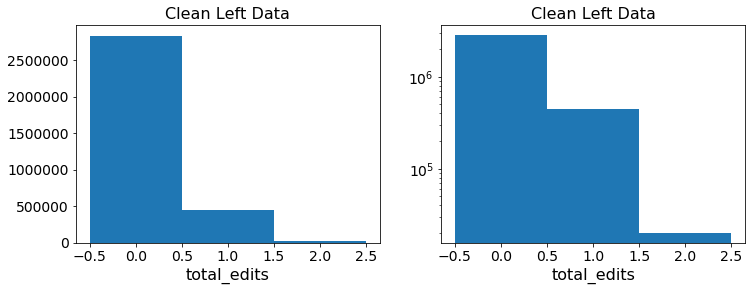

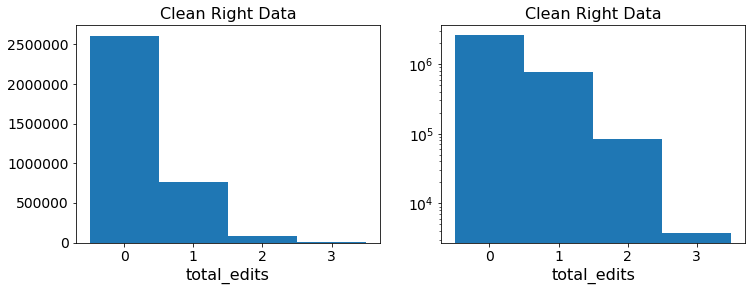

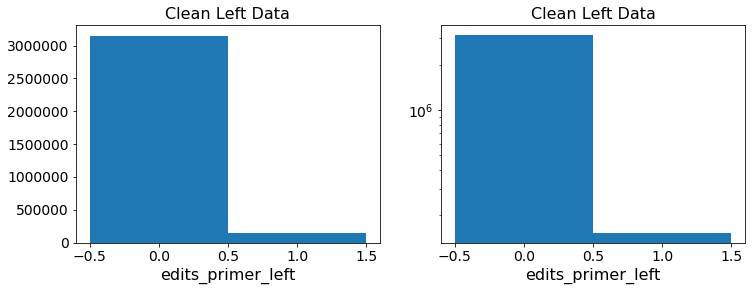

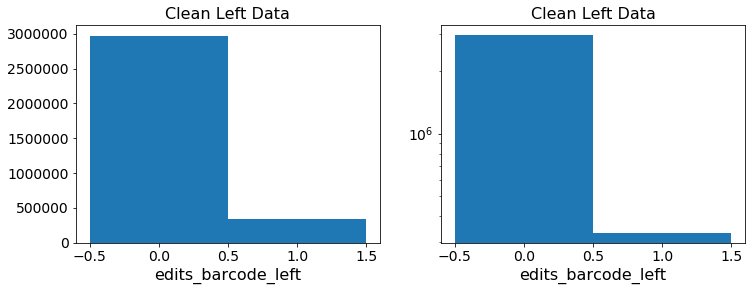

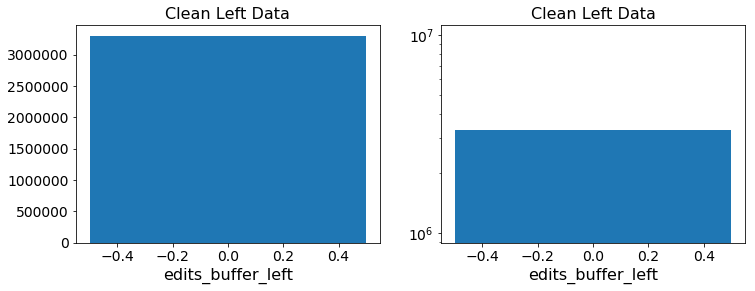

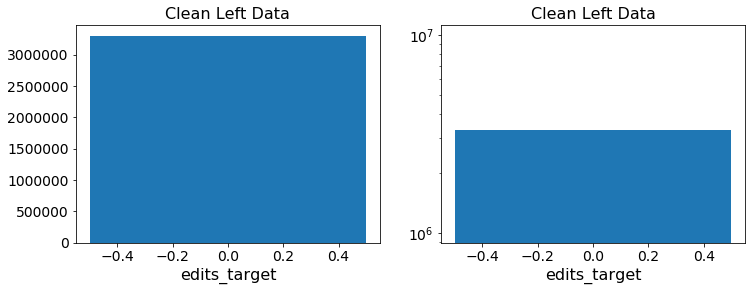

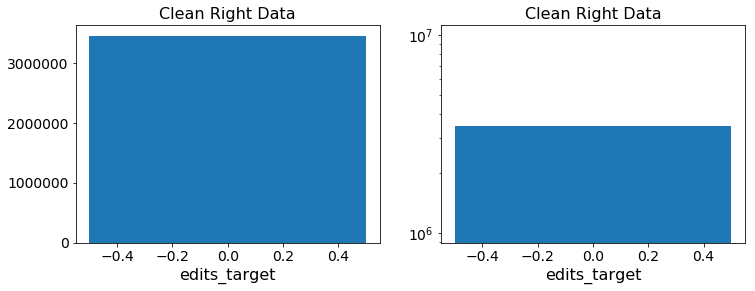

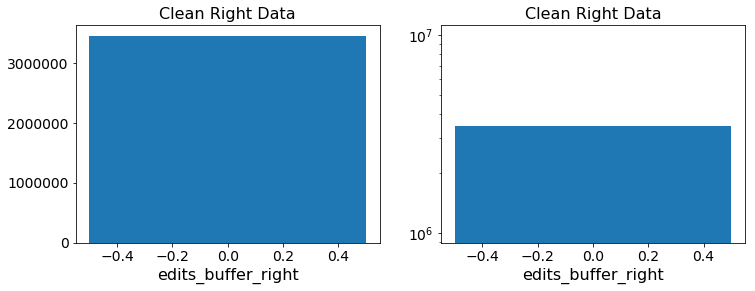

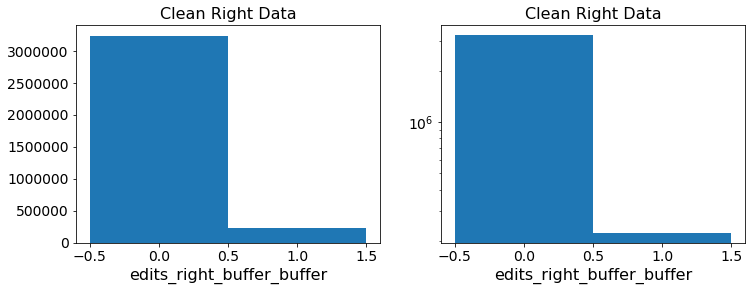

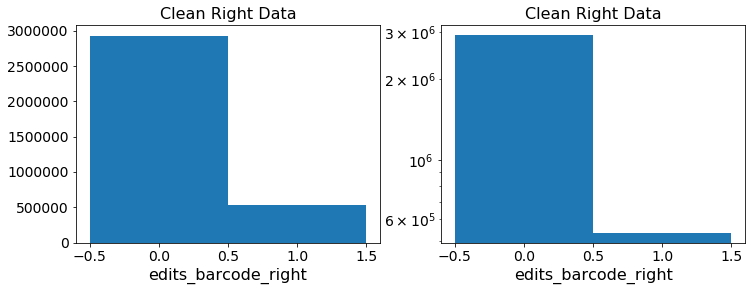

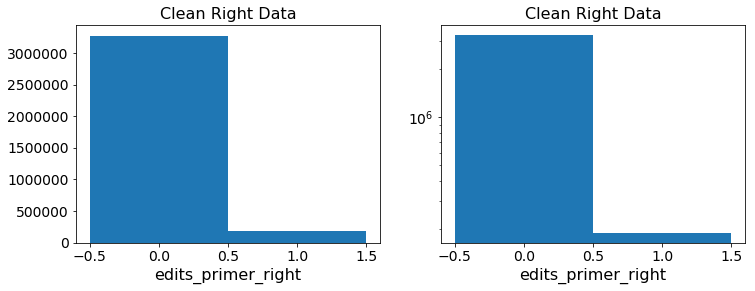

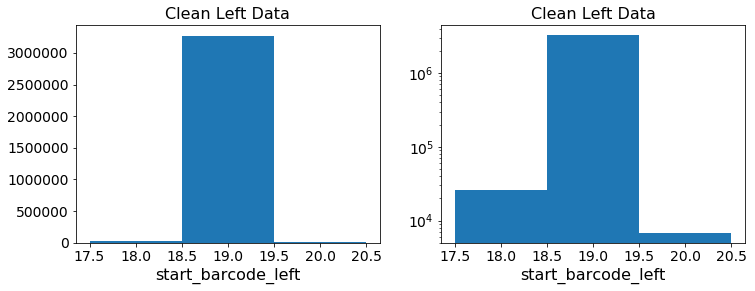

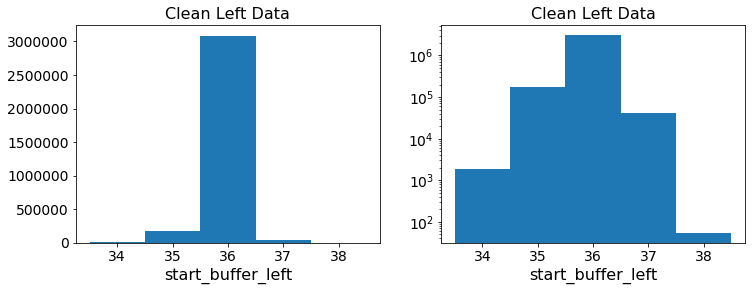

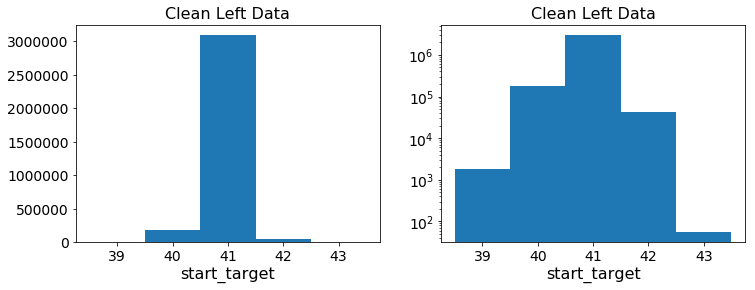

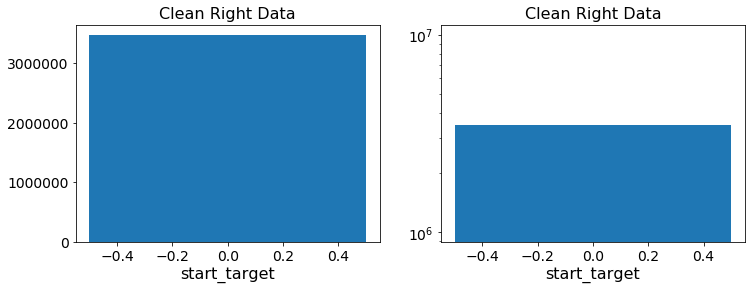

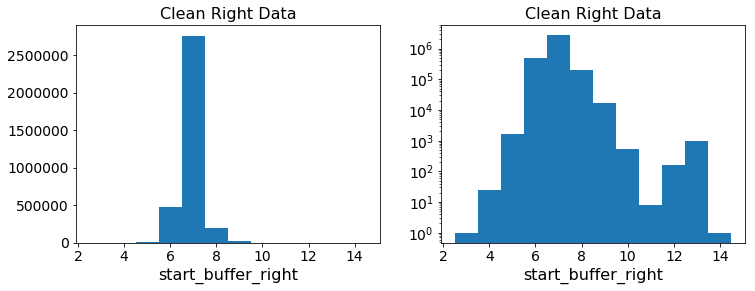

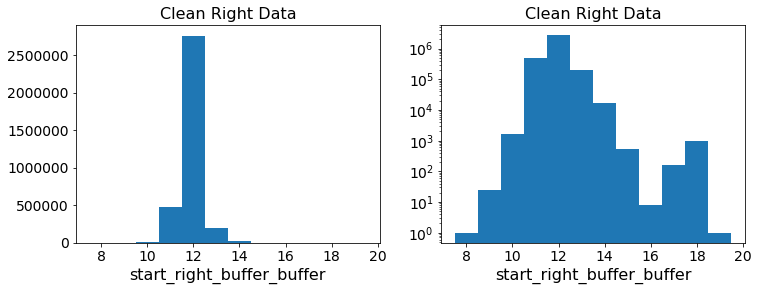

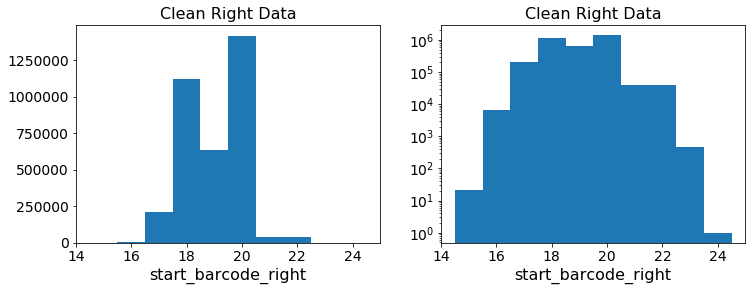

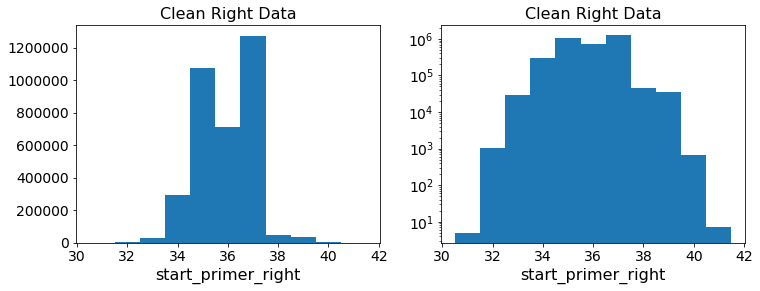

In [27]:
for label in df.columns:
    for side in ['left', 'right']:
        df = cleaned_dfs[side]
        title = 'Clean {} Data'.format(side.capitalize())
        if label in ['read_name', 'sample', 'oriented_seq', 'oligo', 'side'] or 'aligned' in label:
            continue
        if label == 'total_edits':
            data = df[edit_cols].sum(axis=1)
        else:
            new_df = df[np.isfinite(df[label])]
            data = new_df[label]
        if len(data) == 0:
            print 'No data for {} {}'.format(title, label)
            continue
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        ax = axes[0]
        bins = np.arange(min(data), max(data) + 2) - 0.5
        ax.hist(data, bins)
        ax.set_xlabel(label)
        ax.set_title(title)
        ax = axes[1]
        ax.hist(data, bins)
        ax.set_xlabel(label)
        ax.set_yscale('log')
        ax.set_title(title)

We here plot the total sequence count by cut site, given in absolute coordinates.

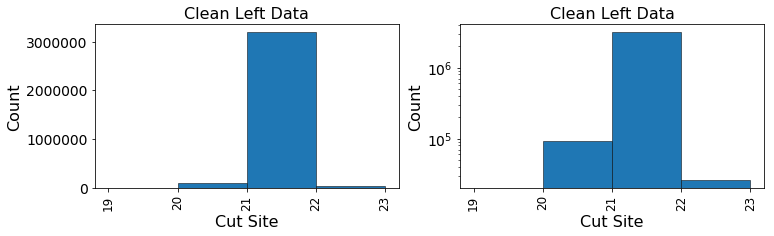

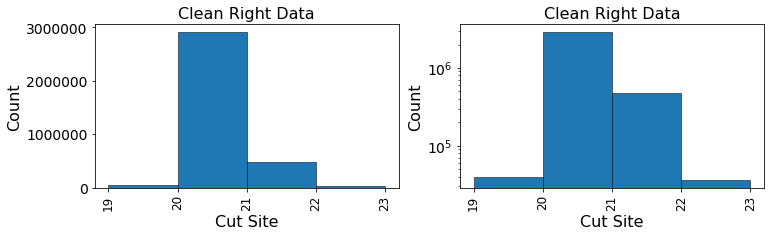

In [28]:
label = 'cut_pamtarg_coord'

# Determine consistent bins
min_data, max_data = float('inf'), float('-inf')
for side in ['left', 'right']:
    df = cleaned_dfs[side]
    new_df = df[np.isfinite(df[label])]
    data = new_df[label]
    min_data = min(min_data, min(data))
    max_data = max(max_data, max(data))

bins = np.arange(min_data, max_data + 2) - 0.5
label_off = pamtarg_pos if pamtarg_pos < len(perfect_target) / 2 else pamtarg_pos + 1
bin_labels = [n if n > 0 else n - 1 for n in map(int, bins + label_off)]

# Plot cut sites
for side in ['left', 'right']:
    df = cleaned_dfs[side]
    title = 'Clean {} Data'.format(side.capitalize())
    new_df = df[np.isfinite(df[label])]
    data = new_df[label]
    if len(data) == 0:
        print 'No data for {} {}'.format(title, label)
        continue
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))
    ax = axes[0]
    ax.hist(data, bins, edgecolor='k', linewidth=0.5)
    ax.set_xticks(bins)
    ax.set_xticklabels(bin_labels, rotation=90, fontsize=12)
    ax.set_xlabel('Cut Site')
    ax.set_ylabel('Count')
    ax.set_title(title)
    ax = axes[1]
    ax.hist(data, bins, edgecolor='k', linewidth=0.5)
    ax.set_xticks(bins)
    ax.set_xticklabels(bin_labels, rotation=90, fontsize=12)
    ax.set_xlabel('Cut Site')
    ax.set_ylabel('Count')
    ax.set_yscale('log')
    ax.set_title(title)
    fig.savefig('figs/{}_'.format(run_label) + title.replace(' ', '') + 'CutSiteHist.png', dpi=300)
    fig.savefig('figs/{}_'.format(run_label) + title.replace(' ', '') + 'CutSiteHist.eps')

# Cut Positions

In [29]:
from freebarcodes import seqtools

In [30]:
from Bio import pairwise2

In [31]:
bases = 'ACGT'

In [32]:
cleaned_pamtarg_tabs = {}
for side in ['left', 'right']:
    df = cleaned_dfs[side]
    cleaned_pamtarg_tabs[side] = pd.crosstab(df.oligo, df.cut_pamtarg_coord)

In [33]:
single_mismatch_targets = seqtools.get_mismatch_seqs(perfect_target, 1)
single_ins_targets = seqtools.get_insertion_seqs(perfect_target, 1)
single_del_targets = seqtools.get_deletion_seqs(perfect_target, 1)

In [34]:
def first_mm(seq):
    for i, (ref_c, obs_c) in enumerate(zip(perfect_target, seq)):
        if ref_c != obs_c:
            return i, ref_c, obs_c

def first_ins(seq):
    alignments = pairwise2.align.globalms(perfect_target, seq, 2, -1, -1, -0.9)
    ref_align, observed_align = alignments[0][:2]
    i = 0
    for i, (ref_c, obs_c) in enumerate(zip(ref_align, observed_align)):
        if ref_c == '-':
            if i + 1 < len(ref_align):
                next_c = ref_align[i + 1]
            else:
                next_c = ''
            return i, obs_c, next_c

def first_del(seq):
    alignments = pairwise2.align.globalms(perfect_target, seq, 2, -1, -1, -0.9)
    ref_align, observed_align = alignments[0][:2]
    i = 0
    for i, (ref_c, obs_c) in enumerate(zip(ref_align, observed_align)):
        if obs_c == '-':
            if i + 1 < len(ref_align):
                next_c = ref_align[i + 1]
            else:
                next_c = ''
            return i, ref_c, next_c

In [35]:
from matplotlib import gridspec
from matplotlib.colors import LogNorm

In [36]:
def print_aligned_target(aligned_target):
    print 'Ref:     ' + '  ' + '  '.join(perfect_target)
    print 'Full:    ' + '  ' + '  '.join(aligned_target[0])
    print 'Obs Cut: ' + '  ' + '  '.join(aligned_target[1])
    print 'Abs Pos: ' + ''.join(['{:3d}'.format(i + 1) for i in range(len(aligned_target[0]))])

## Example Sequences

Check the sequences below to verify cut positions display as desired. Sequences are chosen randomly, so cells can be rerun to look at more examples.

#### Example mismatch seq

In [37]:
side = 'left'
df = cleaned_dfs[side]
while True:
    i = random.randint(1, 100000)
    rec = df.iloc[i]
    target = oligo_container.oligo_given_seq[rec.oligo]._target
    if target in single_mismatch_targets:
        break
print run_label, side, 'record', i
print_aligned_target(rec['aligned_target'])
i, ref_c, obs_c = first_mm(target)
print 'Edit: {}{}{}'.format(ref_c, i+1, obs_c)
print 'Display cut pos: {}'.format(label_from_display_pos(display_pos_given_pamtarg(rec['cut_pamtarg_coord'])))

Cas9_D left record 92704
Ref:       T  T  T  A  G  T  G  A  T  A  A  G  T  G  G  A  A  T  G  C  C  A  T  G  T  G  G
Full:      T  T  T  A  G  T  G  A  T  A  A  G  T  C  G  A  A  T  G  C  C  A  T  G  T  G  G
Obs Cut:   T  T  T  A  G  T  G  A  T  A  A  G  T  C  G  A  A  T  G  C  C  -  -  -  -  -  -
Abs Pos:   1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
Edit: G14C
Display cut pos: 4-3


#### Example insertion seq

In [38]:
side = 'left'
df = cleaned_dfs[side]
while True:
    i = random.randint(1, 100000)
    rec = df.iloc[i]
    target = oligo_container.oligo_given_seq[rec.oligo]._target
    if target in single_ins_targets:
        break
print run_label, side, i
print_aligned_target(rec['aligned_target'])
i, obs_c, next_c = first_ins(target)
print 'Edit: {}{}{}'.format(i, obs_c, i+1)
print 'Display cut pos: {}'.format(label_from_display_pos(display_pos_given_pamtarg(rec['cut_pamtarg_coord'])))

Cas9_D left 53312
Ref:       T  T  T  A  G  T  G  A  T  A  A  G  T  G  G  A  A  T  G  C  C  A  T  G  T  G  G
Full:      T  T  T  A  G  T  G  A  A  T  A  A  G  T  G  G  A  A  T  G  C  C  A  T  G  T  G  G
Obs Cut:   T  T  T  A  G  T  G  A  A  T  A  A  G  T  G  G  A  A  T  G  C  C  -  -  -  -  -  -
Abs Pos:   1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
Edit: 8A9
Display cut pos: 4-3


#### Example deletion seq

In [39]:
side = 'left'
df = cleaned_dfs[side]
while True:
    i = random.randint(1, 100000)
    rec = df.iloc[i]
    target = oligo_container.oligo_given_seq[rec.oligo]._target
    if target in single_del_targets:
        break
print run_label, side, i
print_aligned_target(rec['aligned_target'])
i, ref_c, next_c = first_del(target)
print 'Edit: D{}{}'.format(i+1, ref_c)
print 'Display cut pos: {}'.format(label_from_display_pos(display_pos_given_pamtarg(rec['cut_pamtarg_coord'])))

Cas9_D left 15945
Ref:       T  T  T  A  G  T  G  A  T  A  A  G  T  G  G  A  A  T  G  C  C  A  T  G  T  G  G
Full:      T  T  T  A  G  T  G  T  A  A  G  T  G  G  A  A  T  G  C  C  A  T  G  T  G  G
Obs Cut:   T  T  T  A  G  T  G  T  A  A  G  T  G  G  A  A  T  G  C  C  -  -  -  -  -  -
Abs Pos:   1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
Edit: D8A
Display cut pos: 4-3


# Time Series

In [40]:
combined_norm_factors = np.loadtxt('{}_norm_factors_combined.txt'.format(run_label))

In [41]:
comb_norm_factor_given_sample = {sample: cnf for sample, cnf in zip(sample_names, combined_norm_factors)}
prot_samples = sample_names[1:]
prot_norm_factors = [comb_norm_factor_given_sample[sn] for sn in prot_samples]

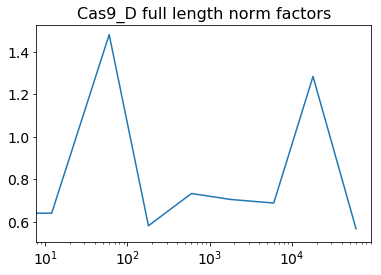

In [42]:
fig, ax = plt.subplots()
ax.plot(times, prot_norm_factors)
ax.set_xscale('log')
ax.set_title('{} full length norm factors'.format(run_label))
print

In [43]:
pamtarg_3d_tab = {}
norm_pamtarg_3d_tab = {}
for side in ['left', 'right']:
    df = cleaned_dfs[side]
    tab = pd.crosstab([df.oligo, df.cut_pamtarg_coord], df['sample'])
    tab = tab[prot_samples]
    pamtarg_3d_tab[side] = tab
    norm_tab = tab.div(np.array(prot_norm_factors), axis='columns')
    norm_tab = norm_tab[prot_samples]
    norm_pamtarg_3d_tab[side] = norm_tab

In [44]:
def standardize_tab(tab):
    for sn in prot_samples:
        if sn not in tab.columns:
            tab[sn] = pd.Series([0]*len(tab), index=tab.index)
    tab = tab[prot_samples]
    mn, mx = min(tab.index.values), max(tab.index.values)
    for i in range(mn, mx+1):
        if i not in tab.index.values:
            prior_size = tab.shape[0]
            tab.loc[i] = [0] * len(tab.columns)
            assert tab.shape[0] == prior_size + 1, tab
    tab = tab.reindex(range(mn, mx+1))
    return tab

# Cut Product Normalization

We observe that the different samples display different amplification biases between full length and cut products. We wish to normalize this using the information from the full length product analysis. Specifically, we assume there exist normalization factors $Z_t^{side}$ for each time $t$ and each side (left or right) which are consistent for all products in said categories, due to each such category having the same sample preparation. After proportionality normalization, we further wish to display results from all sequence on a normalized scale, removing the information of relative abundance of each sequence. These normalizations are performed as described in the NucleaSeq paper.

In [45]:
full_normed_counts_fpath = '{}_normed_read_counts.txt'.format(run_label)
full_normed_counts_given_oligo_seq = {}
full_read_ratios_given_oligo_seq = {}
for line in open(full_normed_counts_fpath):
    words = line.strip().split()
    oligo_seq = words[0]
    read_counts = np.array(map(float, words[1:]))
    if read_counts[0] == 0:
        assert oligo_container.oligo_given_seq[oligo_seq] not in oligo_container.perfect_target_oligos
        denom = 1
    else:
        denom = read_counts[0]
    read_ratios = read_counts / denom
    full_normed_counts_given_oligo_seq[oligo_seq] = read_counts
    full_read_ratios_given_oligo_seq[oligo_seq] = read_ratios

In [46]:
def get_cut_read_summary_dicts(tab_dict):
    cut_read_ratios_given_oligo_seq_given_side = {side: {} for side in ['left', 'right']}
    cut_read_final_count_given_oligo_seq_given_side = {side: {} for side in ['left', 'right']}
    success, failure = 0, 0
    for side in ['left', 'right']:
        for oligo in oligo_container.perfect_target_oligos: #target_oligos
            tab = tab_dict[side]
            try:
                tab = tab.loc[oligo.sequence]
            except:
                failure += 1
                continue
            success += 1
            tab = standardize_tab(tab)
            sum_over_cut_sites = np.array(tab.sum())
            denom = sum_over_cut_sites[-1]
            if denom <= 0:
                denom = 1
            read_ratios = sum_over_cut_sites / denom
            cut_read_ratios_given_oligo_seq_given_side[side][oligo.sequence] = read_ratios
            cut_read_final_count_given_oligo_seq_given_side[side][oligo.sequence] = sum_over_cut_sites[-1]
    #print 'Seq and side found/not found: {:,d} / {:,d}'.format(success, failure)
    return cut_read_ratios_given_oligo_seq_given_side, cut_read_final_count_given_oligo_seq_given_side

In [47]:
cut_read_ratios_given_oligo_seq_given_side, cut_read_final_count_given_oligo_seq_given_side = get_cut_read_summary_dicts(norm_pamtarg_3d_tab)

In [48]:
def find_proportionality_Zs(tab_dict):
    cut_read_ratios_given_oligo_seq_given_side, cut_read_final_count_given_oligo_seq_given_side = get_cut_read_summary_dicts(tab_dict)
    all_full_read_ratios_given_side = {side: [] for side in ['left', 'right']}
    all_cut_read_ratios_given_side = {side: [] for side in ['left', 'right']}
    for side in ['left', 'right']:
        for oligo in oligo_container.perfect_target_oligos:
            full_read_ratios = full_read_ratios_given_oligo_seq[oligo.sequence]
            if all_full_read_ratios_given_side[side]:
                for i, rr in enumerate(full_read_ratios):
                    all_full_read_ratios_given_side[side][i].append(rr)
            else:
                for rr in full_read_ratios:
                    all_full_read_ratios_given_side[side].append([rr])
                    
            cut_read_ratios = cut_read_ratios_given_oligo_seq_given_side[side][oligo.sequence]
            if all_cut_read_ratios_given_side[side]:
                for i, cr in enumerate(cut_read_ratios):
                    all_cut_read_ratios_given_side[side][i].append(cr)
            else:
                for cr in cut_read_ratios:
                    all_cut_read_ratios_given_side[side].append([cr])
                    
    median_full_read_ratios_given_side = {
        side: np.array([np.median(read_ratios) for read_ratios in all_full_read_ratios_given_side[side]])
        for side in ['left', 'right']
    }
    median_cut_read_ratios_given_side = {
        side: np.array([np.median(read_ratios) for read_ratios in all_cut_read_ratios_given_side[side]])
        for side in ['left', 'right']
    }
    
    Zs_given_side = {side: [] for side in ['left', 'right']}
    for side in ['left', 'right']:
        full_rr = median_full_read_ratios_given_side[side]
        cut_rr = median_cut_read_ratios_given_side[side]
        Zs = cut_rr * (1 - full_rr[-1]) / (1 - full_rr)
        assert np.isclose(Zs[-1], 1)
        Zs[0] = 1
        Zs[-1] = 1
        Zs_given_side[side] = Zs
    return Zs_given_side

In [49]:
Zs_given_side = find_proportionality_Zs(norm_pamtarg_3d_tab)

/mnt/marble/hdd2/hawkjo/barcode_and_nucleaseq/src/nucleaseq/envnucleaseq/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in divide


In [50]:
prop_norm_pamtarg_3d_tab = {}
for side in ['left', 'right']:
    tab = norm_pamtarg_3d_tab[side]
    tab = tab[prot_samples]
    prop_norm_tab = tab.div(np.array(Zs_given_side[side]), axis='columns')
    prop_norm_tab = prop_norm_tab[prot_samples]
    prop_norm_pamtarg_3d_tab[side] = prop_norm_tab

In [51]:
def get_major_sites_ys_and_meds(tab_in):
    sites = set()
    tf_full_read_ratios = []
    for oligo in oligo_container.perfect_target_oligos:
        tab = tab_in
        tab = tab.loc[oligo.sequence]
        tab = standardize_tab(tab)
        tab = tab.T

        max_binval = max(tab.max())
        total = tab.sum().sum()

        sites.update([rawpos for rawpos in tab.columns])
        tf_full_read_ratios.append(full_read_ratios_given_oligo_seq[oligo.sequence][-1])

    ys_given_site = defaultdict(list)
    tf_sums = []
    for oligo in oligo_container.perfect_target_oligos:
        tab = tab_in
        tab = tab.loc[oligo.sequence]
        tab = standardize_tab(tab)
        tab = tab.T

        max_binval = max(tab.max())
        total = tab.sum().sum()
        tf_sums.append(tab.loc[sample_names[-1]].sum()/float(total))


        for idx, site in enumerate(sites):
            if site in tab:
                y = tab[site]
                y = np.array(y) / float(total)
                ys_given_site[site].append(y)
            else:
                ys_given_site[site].append([0]*len(times))
            
    meds_given_site = {site: [np.median([y[i] for y in ys]) for i in range(len(times))] 
                       for site, ys in ys_given_site.items()}

    major_sites = set()
    #max_med_val = max(max(meds) for meds in meds_given_site.values())
    max_med_val = max(sum(meds_given_site[site][i] for site in sites) for i in range(len(times)))
    for site, meds in meds_given_site.items():
        if max(meds) > 0.1 * max_med_val:
            major_sites.add(site)
            
    return major_sites, sites, ys_given_site, meds_given_site, tf_full_read_ratios, tf_sums

In [52]:
cut_start_thresh = 0.33

tab_dict = prop_norm_pamtarg_3d_tab
sides = ['left', 'right']
starts = {side: [] for side in sides}
stops = {side: [] for side in sides}
for i, side in enumerate(sides):
    sites = set()
    major_sites, sites, ys_given_site, _, tf_full_read_ratios, tf_sums = get_major_sites_ys_and_meds(tab_dict[side])

    Z_display = np.median(tf_sums) / (1.0 - np.median(tf_full_read_ratios))
    ys_given_site = {site: [y/Z_display for y in ys] for site, ys in ys_given_site.items()}

    avgs_given_site = {site: [np.average([y[i] for y in ys]) for i in range(len(times))] 
                       for site, ys in ys_given_site.items()}

    for time_idx in range(1, len(times)):
        vals_and_cut_pos = []
        for site, y in sorted(avgs_given_site.items()):
            display_cut_pos = display_pos_given_pamtarg(site)
            vals_and_cut_pos.append((y[time_idx], display_cut_pos))
        val_sum = sum(tup[0] for tup in vals_and_cut_pos)
        if val_sum > cut_start_thresh:
            avg_cut_pos = sum(tup[0] * tup[1] for tup in vals_and_cut_pos) / val_sum
            starts[side].append(avg_cut_pos)
            break

    time_idx = -1
    vals_and_cut_pos = []
    for site, y in sorted(avgs_given_site.items()):
        display_cut_pos = display_pos_given_pamtarg(site)
        vals_and_cut_pos.append((y[time_idx], display_cut_pos))
    val_sum = sum(tup[0] for tup in vals_and_cut_pos)
    avg_cut_pos = sum(tup[0] * tup[1] for tup in vals_and_cut_pos) / val_sum
    stops[side].append(avg_cut_pos)

perfect_start_avg = {side: np.average(cut_pos_list) for side, cut_pos_list in starts.items()}
perfect_stop_avg = {side: np.average(cut_pos_list) for side, cut_pos_list in stops.items()}

In [53]:
def build_single_ys_given_site(side, tseq_or_oligo, tab_dict):
    if isinstance(tseq_or_oligo, str):
        oligo = unique_oligo_given_target(tseq_or_oligo)
    else:
        oligo = tseq_or_oligo
    tab = tab_dict[side]
    tab = tab.loc[oligo.sequence]
    tab = standardize_tab(tab)
    tab = tab.T

    max_binval = max(tab.max())
    total = tab.sum().sum()
    tf_sum = tab.loc[sample_names[-1]].sum()

    sites = [rawpos for rawpos in tab.columns if max(tab[rawpos]) > 0.1 * max_binval]

    Z_display = tf_sum / (1.0 - full_read_ratios_given_oligo_seq[oligo.sequence][-1])
    ys_given_site = defaultdict(list)
    for idx, site in enumerate(sites):
        y = tab[site]
        y = np.array(y) / Z_display
        ys_given_site[site].append(y)
    return ys_given_site

def start_and_stop_avg_cut_pos(side, tseq_or_oligo, tab_dict):
    ys_given_site = build_single_ys_given_site(side, tseq_or_oligo, tab_dict)
    for time_idx in range(1, len(times)):
        vals_and_cut_pos = []
        for site, ys in sorted(ys_given_site.items()):
            for k, y in enumerate(ys):
                assert k == 0, k
                display_cut_pos = display_pos_given_pamtarg(site)
                vals_and_cut_pos.append((y[time_idx], display_cut_pos))
        val_sum = sum(tup[0] for tup in vals_and_cut_pos)
        if val_sum > cut_start_thresh:
            start_avg_cut_pos = sum(tup[0] * tup[1] for tup in vals_and_cut_pos) / val_sum
            break
    else:
        start_avg_cut_pos = None

    time_idx = -1
    vals_and_cut_pos = []
    for site, ys in sorted(ys_given_site.items()):
        for k, y in enumerate(ys):
            assert k == 0, k
            display_cut_pos = display_pos_given_pamtarg(site)
            vals_and_cut_pos.append((y[time_idx], display_cut_pos))
    val_sum = sum(tup[0] for tup in vals_and_cut_pos)
    if val_sum:
        stop_avg_cut_pos = sum(tup[0] * tup[1] for tup in vals_and_cut_pos) / val_sum
    else:
        stop_avg_cut_pos = None
    return start_avg_cut_pos, stop_avg_cut_pos

## Before normalization

In [54]:
def plot_major_perfects(tab_dict):
    for side in ['left', 'right']:
        major_sites, sites, ys_given_site, meds_given_site, _, _ = get_major_sites_ys_and_meds(tab_dict[side])

        fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw=dict(wspace=0.3))
        ax = axes[0]
        for site in sorted(major_sites):
            ys = ys_given_site[site]
            label = label_from_display_pos(display_pos_given_pamtarg(site))
            color, ls = color_and_linestyle(side, display_pos_given_pamtarg(site))
            for i, y in enumerate(ys):
                if i == 0:
                    ax.plot([times[0]]*2, [0]*2, color=color, label=label, ls=ls)
                ax.plot(times, y, color=color, alpha=0.2, ls=ls)
        title = '{} at Major Sites'.format(side.capitalize())
        ax.set_title(title)
        ax.set_xscale('log')
        ylim = ax.get_ylim()

        ax = axes[1]
        for site, meds in sorted(meds_given_site.items()):
            if site not in major_sites:
                continue
            label = label_from_display_pos(display_pos_given_pamtarg(site))
            color, ls = color_and_linestyle(side, display_pos_given_pamtarg(site))
            ax.plot(times, meds, ls=ls, linewidth=3, color=color, label=label)
        if len(major_sites) > 1:
            med_sum = [sum(meds_given_site[site][i] for site in major_sites) for i in range(len(times))]
            ax.plot(times, med_sum, color=0.8*np.ones((3,)), linewidth=3, label='Sum', zorder=-1)
        title = 'Medians'
        ax.set_title(title)
        ylim = ax.get_ylim()
        ax.set_ylim((ylim[0], 1.1*ylim[1]))

        for ax in axes:
            ax.legend(loc='upper left')
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Normalized Counts')


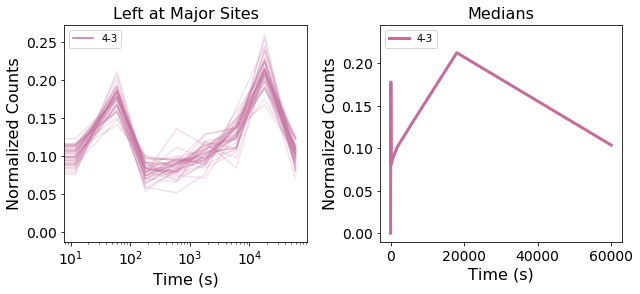

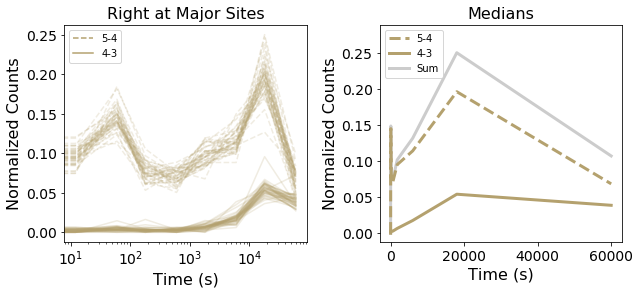

In [55]:
plot_major_perfects(pamtarg_3d_tab)

## After Normalization

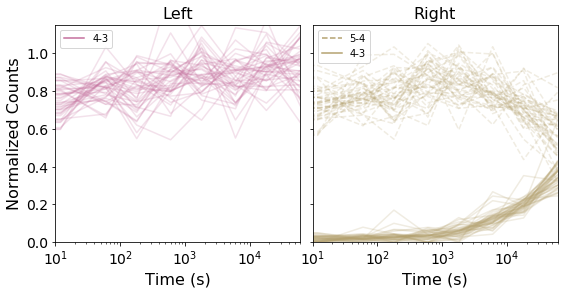

In [56]:
def plot_major_perfects_final(tab_dict):
    fig, axes = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw=dict(wspace=0.05))
    for ax, side in zip(axes, sides):
        major_sites, sites, ys_given_site, _, tf_full_read_ratios, tf_sums = get_major_sites_ys_and_meds(tab_dict[side])

        Z_display = np.median(tf_sums) / (1.0 - np.median(tf_full_read_ratios))
        ys_given_site = {site: [y/Z_display for y in ys] for site, ys in ys_given_site.items()}

        for site in sorted(major_sites):
            ys = ys_given_site[site]
            label = label_from_display_pos(display_pos_given_pamtarg(site))
            color, ls = color_and_linestyle(side, display_pos_given_pamtarg(site))
            for i, y in enumerate(ys):
                if i == 0:
                    ax.plot(2*[times[-1]], [0, 0], color=color, label=label, ls=ls)
                ax.plot(times, y, color=color, alpha=0.2, ls=ls)
        title = '{}'.format(side.capitalize())
        ax.set_title(title)
        ax.set_xscale('log')
        ax.set_ylim((0, 1.15))
        ax.set_xlim((10, times[-1]))

        ax.legend(loc='upper left')
        ax.set_xlabel('Time (s)')
        if side == 'left':
            ax.set_ylabel('Normalized Counts')
        else:
            ax.set_yticklabels([])
    return fig, axes

fig, axes = plot_major_perfects_final(prop_norm_pamtarg_3d_tab)
fig.savefig('{}_perfect_cut_sites_v_time.eps'.format(run_label))
fig.savefig('{}_perfect_cut_sites_v_time.png'.format(run_label), dpi=300)

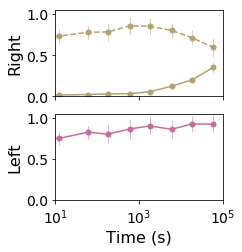

In [57]:
from scipy.stats import sem

traces_fig_dir = 'figs/{}_traces'.format(run_label)
if not os.path.exists(traces_fig_dir):
    os.mkdir(traces_fig_dir)

tab_dict = prop_norm_pamtarg_3d_tab
stds_maxes = [0 for _ in range(len(times))]
fig, axes = plt.subplots(2, 1, figsize=(3, 3.5), gridspec_kw=dict(wspace=0.05))
for i, side in enumerate(sides):
    ax = axes[1-i]

    major_sites, sites, ys_given_site, _, tf_full_read_ratios, tf_sums = get_major_sites_ys_and_meds(tab_dict[side])

    Z_display = np.median(tf_sums) / (1.0 - np.median(tf_full_read_ratios))
    ys_given_site = {site: [y/Z_display for y in ys] for site, ys in ys_given_site.items()}

    avgs_given_site = {site: [np.average([y[i] for y in ys]) for i in range(len(times))] 
                       for site, ys in ys_given_site.items()}
    stds_given_site = {site: [np.std([y[i] for y in ys]) for i in range(len(times))] 
                       for site, ys in ys_given_site.items()}
    stds_maxes = [max([stds_maxes[t_idx]] + [stds_given_site[site][t_idx] for site in sites])
                  for t_idx in range(len(times))]

    for site_idx, site in enumerate(sorted(major_sites)):
        x = times
        y = avgs_given_site[site]
        yerr = stds_given_site[site]
        label = label_from_display_pos(display_pos_given_pamtarg(site))
        color, ls = color_and_linestyle(side, display_pos_given_pamtarg(site))
        ax.errorbar(x, y, yerr=yerr, linewidth=0.5, color=color, zorder=-1, fmt='none')
        ax.plot(x, y, color=color, label=label, linestyle=ls)
        ax.plot(x, y, 'o', markersize=5, color=color)

    ax.set_xscale('log')
    ax.set_ylim((0, 1.05))
    ax.set_xlim((10, 1e5))
    if ax == axes[0]:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Time (s)')

    #ax.legend(loc='upper left')
    ax.set_ylabel(side.capitalize())

fig.savefig(os.path.join(traces_fig_dir, '{}_perfect_cut_site_traces.eps'.format(run_label)))
fig.savefig(os.path.join(traces_fig_dir, '{}_perfect_cut_site_traces.png'.format(run_label)), dpi=300)

## Single mismatch cut seqs

In [58]:
import math

In [59]:
if pamtarg_pos < len(perfect_target)/2:
    display_offset = -0.5
else:
    display_offset = 0.5

In [60]:
def mm_seqs_given_pos(mm_pos):
    for base in bases.replace(perfect_target[mm_pos], ''):
        yield base, perfect_target[:mm_pos] + base + perfect_target[mm_pos+1:]
        
def unique_oligo_given_target(target_seq):
    target_oligos = [oligo for oligo in oligo_container.target_oligos if oligo._target == target_seq]
    return target_oligos[0]


In [61]:
from collections import namedtuple

def try_float(x):
    try:
        return float(x)
    except:
        return x

cleavage_rates_given_target = defaultdict(list)
with open('{}_cleavage_rate_and_y0.txt'.format(run_label)) as f:
    line = next(f).strip()
    Record = namedtuple('Record', line)
    for line in f:
        stuff = map(try_float, line.strip().split('\t'))
        r = Record(*stuff)
        cleavage_rates_given_target[r.target].append(r.cleavage_rate)

/mnt/marble/hdd2/hawkjo/barcode_and_nucleaseq/src/nucleaseq/envnucleaseq/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in divide
/mnt/marble/hdd2/hawkjo/barcode_and_nucleaseq/src/nucleaseq/envnucleaseq/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in divide


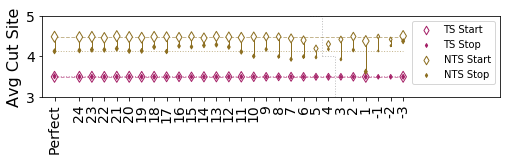

In [62]:
scatter_mult = 15

starts = {side: np.zeros((4, len(perfect_target))) for side in sides}
stops = {side: np.zeros((4, len(perfect_target))) for side in sides}
tab_dict = prop_norm_pamtarg_3d_tab
for mm_pos in range(len(perfect_target)):
    for i, side in enumerate(['left', 'right']):
        for j, (mm_base, target_seq) in enumerate(mm_seqs_given_pos(mm_pos)):
            start_avg_cut_pos, stop_avg_cut_pos = start_and_stop_avg_cut_pos(side, target_seq, tab_dict)
            starts[side][bases.index(mm_base), mm_pos] = start_avg_cut_pos
            stops[side][bases.index(mm_base), mm_pos] = stop_avg_cut_pos

log10_mm_pos_cleavage_rate_avg = []
for mm_pos in range(len(perfect_target)):
    all_cleave_rs = []
    for mm_base, target_seq in mm_seqs_given_pos(mm_pos):
        all_cleave_rs.extend(cleavage_rates_given_target[target_seq])
    log10_mm_pos_cleavage_rate_avg.append(np.log10(np.average(all_cleave_rs)))

fig, ax = plt.subplots(figsize=(8.2, 1.5))
label_given_side = {'left': 'TS', 'right': 'NTS'}
perfect_x = -2
xticks = [perfect_x] + list(np.arange(len(perfect_target)))
xticklabels = ['Perfect'] + [display_pos_given_abs(xx) for xx in xticks[1:]]
ymin, ymax = float('inf'), float('-inf')
offset = 0.3
for i, side in enumerate(sides):
    ys = []
    for i, (mats, mark_color, label_suffix, perfect_avg_d, perfect_ls, mult_adjust) in enumerate(
        [(starts, 'w', 'Start', perfect_start_avg, '--', 1), 
         (stops, base_color_given_side[side], 'Stop', perfect_stop_avg, ':', 0.2)]
    ):
        M = mats[side]
        M[M == 0] = np.nan
        y = np.nanmean(M, axis=0)
        y = np.array([perfect_avg_d[side]] + list(y))
        y += display_offset
        ys.append(y)
        s = scatter_mult * mult_adjust * np.array([lipcr - np.log10(np.log(2)/times[-1])
                                                   for lipcr in log10_mm_pos_cleavage_rate_avg])
        x = [perfect_x] + list(np.arange(len(y)-1))
        label = '{} {}'.format(label_given_side[side], label_suffix)
        ax.scatter(x, y, s=s, facecolors=mark_color,
                   color=base_color_given_side[side], label=label, marker='d')
        ax.plot([xticks[0], xticks[-1]], [perfect_avg_d[side] + display_offset]*2,
                color=base_color_given_side[side], alpha=0.5, linestyle=perfect_ls, 
                linewidth=1, zorder=-1)
        ymin, ymax = min(min(y), ymin), max(max(y), ymax)
    for xx, yy1, yy2 in zip(x, *ys):
        ax.plot([xx]*2, [yy1, yy2], color=base_color_given_side[side], linewidth=1, zorder=-1)
yrange = ymax-ymin
ymin = int(math.floor(ymin-0.1*yrange))
ymax = int(math.ceil(ymax+0.1*yrange))
ylim = (ymin, ymax)
yint = next(i for i in range(1, 10) if (ymax - ymin)/float(i) < 5.0)
yticks = range(ymin, ymax+1, yint)
if pamtarg_pos < len(perfect_target)/2:
    for abs_pos in range(ylim[0] + pamtarg_pos - 1, len(perfect_target)):
        kw_args = dict(linestyle=':', color='grey', linewidth=1, zorder=-1, alpha=0.5)
        display_pos = display_pos_given_abs(abs_pos)
        ax.plot([abs_pos - 0.5]*2, [display_pos-1, display_pos], **kw_args)
        ax.plot([abs_pos - 0.5, abs_pos + 0.5], [display_pos, display_pos], **kw_args)
else:
    for abs_pos in range(int(abs_pos_given_display(ylim[1])), int(abs_pos_given_display(ylim[0])) + 1):
        kw_args = dict(linestyle=':', color='grey', linewidth=1, zorder=-1, alpha=0.5)
        display_pos = display_pos_given_abs(abs_pos)
        ax.plot([abs_pos - 0.5]*2, [display_pos, display_pos_given_abs(abs_pos-1)], **kw_args)
        ax.plot([abs_pos - 0.5, abs_pos + 0.5], [display_pos, display_pos], **kw_args)
ax.set_yticks(yticks)
ax.set_ylim(ylim)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=90)
ax.set_xlim([xticks[0]-1, len(perfect_target)*1.25])
ax.set_ylabel('Avg Cut Site')
ax.legend()
fig.savefig('figs/{}_mm_avg_start_stop_cut_sites.png'.format(run_label), dpi=300)
fig.savefig('figs/{}_mm_avg_start_stop_cut_sites.eps'.format(run_label))

/mnt/marble/hdd2/hawkjo/barcode_and_nucleaseq/src/nucleaseq/envnucleaseq/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in divide
/mnt/marble/hdd2/hawkjo/barcode_and_nucleaseq/src/nucleaseq/envnucleaseq/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in divide


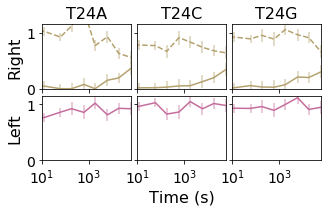

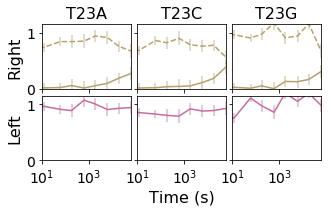

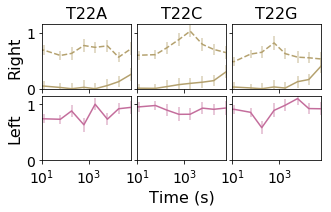

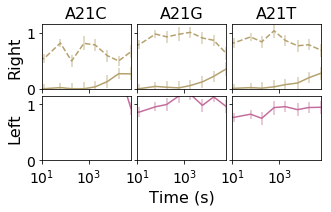

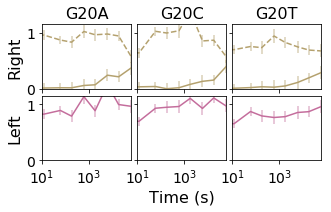

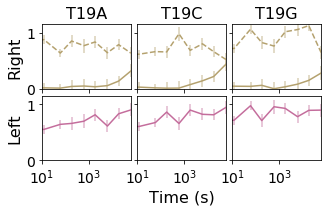

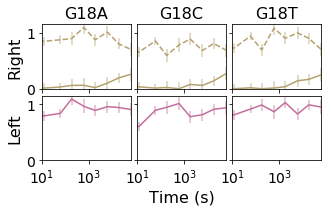

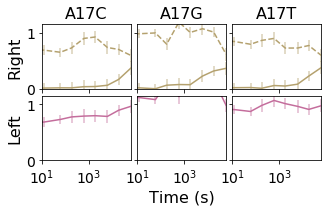

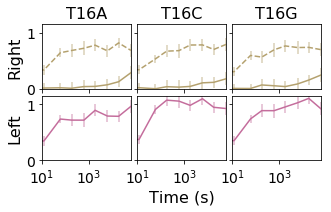

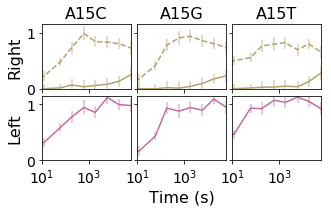

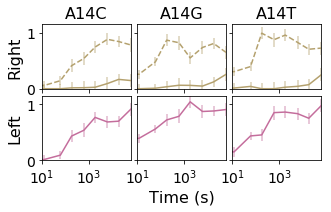

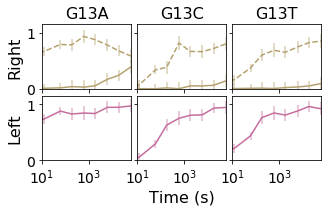

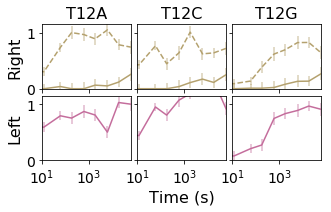

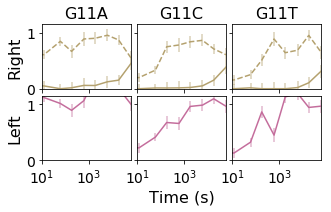

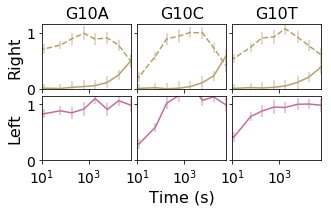

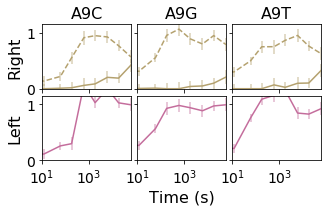

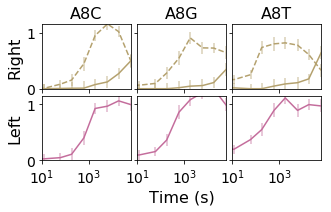

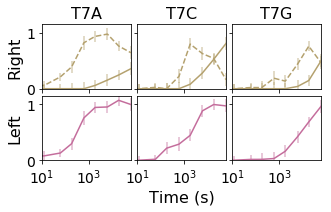

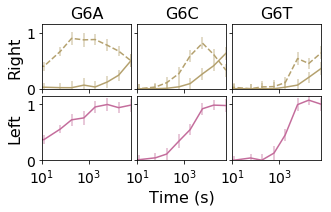

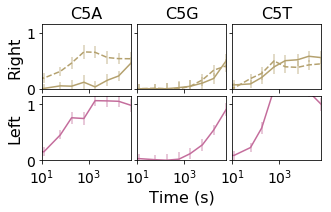

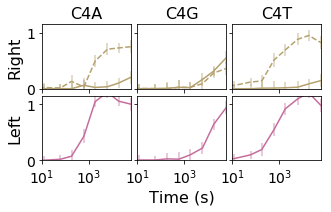

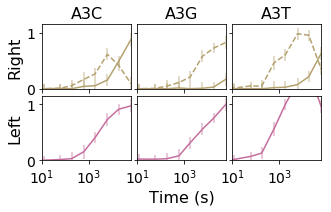

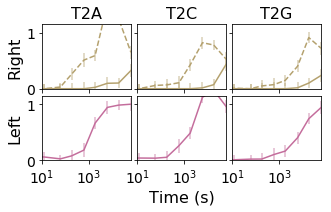

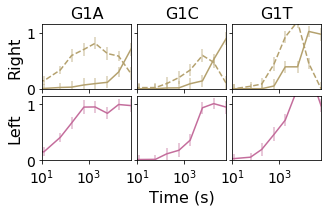

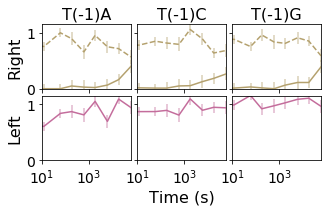

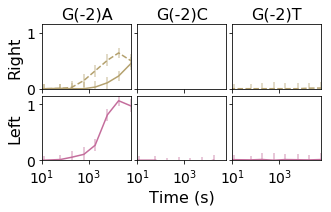

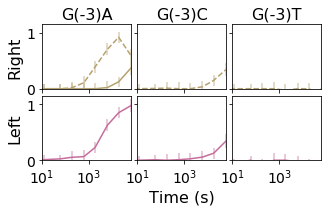

In [63]:
def plot_mm_pos_seqs(tab_dict, mm_pos):
    fig, axes = plt.subplots(2, 3, figsize=(5, 2.5), gridspec_kw=dict(wspace=0.07, hspace=0.11))
    for i, side in enumerate(['left', 'right']):
        i = 1-i
        for j, (mm_base, target_seq) in enumerate(mm_seqs_given_pos(mm_pos)):
            ax = axes[i, j]
            ys_given_site = build_single_ys_given_site(side, target_seq, tab_dict)
            for site, ys in sorted(ys_given_site.items()):
                for k, y in enumerate(ys):
                    assert k == 0, k
                    display_mm_pos = display_pos_given_abs(mm_pos)
                    label = label_from_display_pos(display_pos_given_pamtarg(site))
                    try:
                        color, ls = color_and_linestyle(side, display_pos_given_pamtarg(site))
                    except:
                        title = '{}{}{}'.format(perfect_target[mm_pos], display_mm_pos, mm_base)
                        print 'Failed', title, label
                        continue
                    ax.errorbar(times, y, yerr=stds_maxes, color=color, alpha=0.5, zorder=-1, fmt='none')
                    ax.plot(times, y, color=color, linestyle=ls, label=label)
            ax.set_xscale('log')
            ax.set_xlim((10, times[-1]))
            ax.set_ylim((0, 1.15))
            ax.set_yticks((0, 1))
            #ax.legend(loc='upper left')
            if i == 0:
                display_mm_pos = display_pos_given_abs(mm_pos)
                if display_mm_pos >= 0:
                    title = '{}{}{}'.format(perfect_target[mm_pos], display_mm_pos, mm_base)
                else:
                    title = '{}({}){}'.format(perfect_target[mm_pos], display_mm_pos, mm_base)
                ax.set_title(title)
                ax.set_xticklabels([])
            if i == j == 1:
                ax.set_xlabel('Time (s)')
            if j == 0:
                ax.set_ylabel(side.capitalize())
            else:
                ax.set_yticklabels([])
    return fig, ax


for i in range(len(perfect_target)):
    mm_pos = i - 4
    if mm_pos >= 0:
        mm_pos += 1
    fig, ax = plot_mm_pos_seqs(prop_norm_pamtarg_3d_tab, i)
    fig.savefig(os.path.join(traces_fig_dir, '{}_mm_{}_cut_site_traces.png'.format(run_label, mm_pos)), dpi=300)
    fig.savefig(os.path.join(traces_fig_dir, '{}_mm_{}_cut_site_traces.eps'.format(run_label, mm_pos)))

# Single insertions

In [64]:
def ins_seqs_given_pos(ins_pos):
    for base in bases:
        yield base, perfect_target[:ins_pos] + base + perfect_target[ins_pos:]

/mnt/marble/hdd2/hawkjo/barcode_and_nucleaseq/src/nucleaseq/envnucleaseq/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in divide
/mnt/marble/hdd2/hawkjo/barcode_and_nucleaseq/src/nucleaseq/envnucleaseq/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in divide
/mnt/marble/hdd2/hawkjo/barcode_and_nucleaseq/src/nucleaseq/envnucleaseq/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


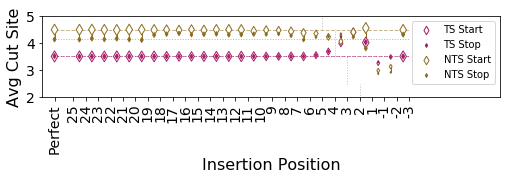

In [65]:
from matplotlib.colors import LinearSegmentedColormap

starts = {side: np.zeros((4, len(perfect_target))) for side in sides}
stops = {side: np.zeros((4, len(perfect_target))) for side in sides}
tab_dict = prop_norm_pamtarg_3d_tab
for ins_pos in range(len(perfect_target)):
    for i, side in enumerate(['left', 'right']):
        for j, (ins_base, target_seq) in enumerate(ins_seqs_given_pos(ins_pos)):
            try:
                start_avg_cut_pos, stop_avg_cut_pos = start_and_stop_avg_cut_pos(side, target_seq, tab_dict)
            except:
                continue
            starts[side][bases.index(ins_base), ins_pos] = start_avg_cut_pos
            stops[side][bases.index(ins_base), ins_pos] = stop_avg_cut_pos

log10_ins_pos_cleavage_rate_avg = []
for ins_pos in range(len(perfect_target)):
    all_cleave_rs = []
    for ins_base, target_seq in ins_seqs_given_pos(ins_pos):
        all_cleave_rs.extend(cleavage_rates_given_target[target_seq])
    log10_ins_pos_cleavage_rate_avg.append(np.log10(np.average(all_cleave_rs)))

fig, ax = plt.subplots(figsize=(8.2, 1.5))
label_given_side = {'left': 'TS', 'right': 'NTS'}
perfect_x = -2
ymin, ymax = float('inf'), float('-inf')
for i, side in enumerate(sides):
    offset = 0.3
    xticks = [perfect_x] + list(np.arange(len(perfect_target)+1) - 0.5)
    xticklabels = ['Perfect'] + [display_pos_given_abs(int(xx-0.5)) for xx in xticks[1:]]
    ys = []
    for i, (mats, mark_color, label_suffix, perfect_avg_d, perfect_ls, mult_adjust) in enumerate(
        [(starts, 'w', 'Start', perfect_start_avg, '--', 1), 
         (stops, base_color_given_side[side], 'Stop', perfect_stop_avg, ':', 0.2)]
    ):
        M = mats[side]
        M[M == 0] = np.nan
        y = np.nanmean(M, axis=0)
        y = np.array([perfect_avg_d[side]] + list(y))
        y += display_offset
        ys.append(y)
        s = scatter_mult * mult_adjust * np.array([lipcr - np.log10(np.log(2)/times[-1])
                                                   for lipcr in log10_mm_pos_cleavage_rate_avg])
        x = [perfect_x] + list(np.arange(len(y)-1))
        label = '{} {}'.format(label_given_side[side], label_suffix)
        ax.scatter(x, y, s=s, facecolors=mark_color,
                   color=base_color_given_side[side], label=label, marker='d')
        ax.plot([xticks[0], xticks[-1]], [perfect_avg_d[side] + display_offset]*2,
                color=base_color_given_side[side], alpha=0.5, linestyle=perfect_ls, 
                linewidth=1, zorder=-1)
        ymin, ymax = min(min(y), ymin), max(max(y), ymax)
    for xx, yy1, yy2 in zip(x, *ys):
        ax.plot([xx]*2, [yy1, yy2], color=base_color_given_side[side], linewidth=1, zorder=-1)
yrange = ymax-ymin
ymin = int(math.floor(ymin-0.1*yrange))
ymax = int(math.ceil(ymax+0.1*yrange))
ylim = (ymin, ymax)
yint = next(i for i in range(1, 10) if (ymax - ymin)/float(i) < 5.0)
yticks = range(ymin, ymax+1, yint)
if pamtarg_pos < len(perfect_target)/2:
    for abs_pos in range(ylim[0] + pamtarg_pos - 1, len(perfect_target)):
        kw_args = dict(linestyle=':', color='grey', linewidth=1, zorder=-1, alpha=0.5)
        display_pos = display_pos_given_abs(abs_pos)
        ax.plot([abs_pos - 0.5]*2, [display_pos-1.5, display_pos-0.5], **kw_args)
        ax.plot([abs_pos - 0.5, abs_pos + 0.5], [display_pos-0.5]*2, **kw_args)
else:
    for abs_pos in range(int(abs_pos_given_display(ylim[1])), int(abs_pos_given_display(ylim[0])) + 1):
        kw_args = dict(linestyle=':', color='grey', linewidth=1, zorder=-1, alpha=0.5)
        display_pos = display_pos_given_abs(abs_pos)
        ax.plot([abs_pos + 0.5]*2, [display_pos-0.5, display_pos_given_abs(abs_pos-1)-0.5], **kw_args)
        ax.plot([abs_pos + 0.5, abs_pos + 0.5], [display_pos-0.5]*2, **kw_args)
ax.set_ylim(ylim)
ax.set_yticks(yticks)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=90)
ax.set_xlim([xticks[0]-1, len(perfect_target)*1.25])
ax.set_xlabel('Insertion Position')
ax.set_ylabel('Avg Cut Site')
ax.legend()
fig.savefig('figs/{}_ins_avg_start_stop_cut_sites.png'.format(run_label), dpi=300)
fig.savefig('figs/{}_ins_avg_start_stop_cut_sites.eps'.format(run_label))

/mnt/marble/hdd2/hawkjo/barcode_and_nucleaseq/src/nucleaseq/envnucleaseq/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in divide
/mnt/marble/hdd2/hawkjo/barcode_and_nucleaseq/src/nucleaseq/envnucleaseq/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in divide


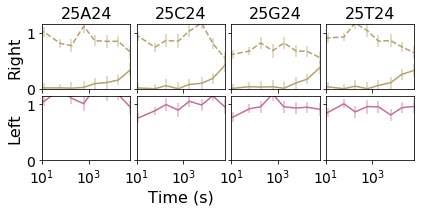

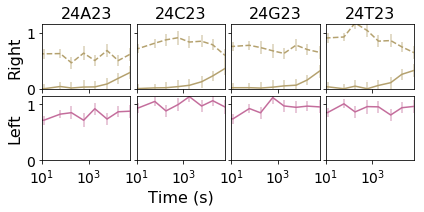

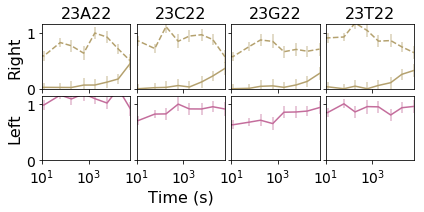

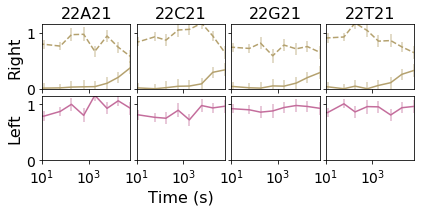

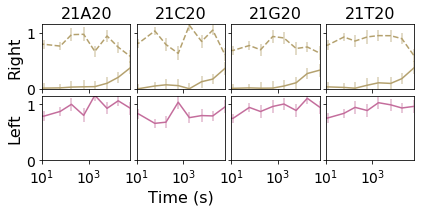

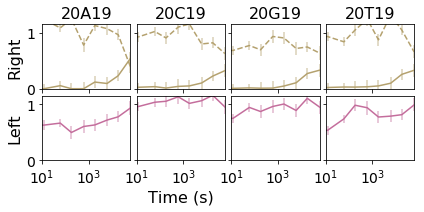

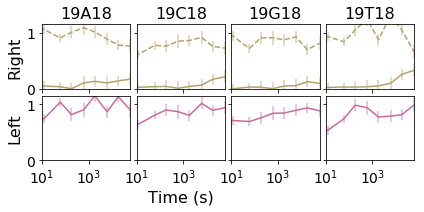

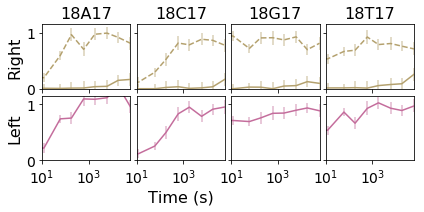

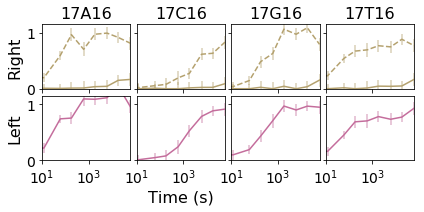

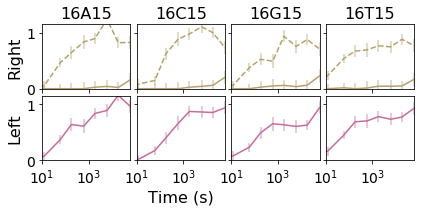

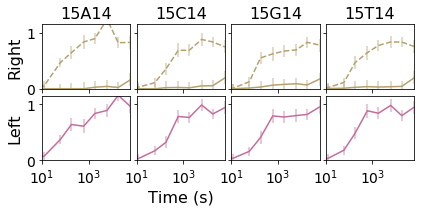

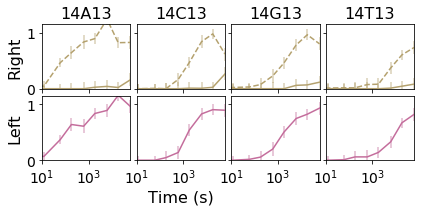

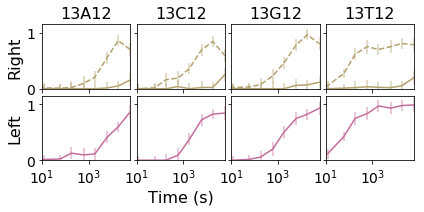

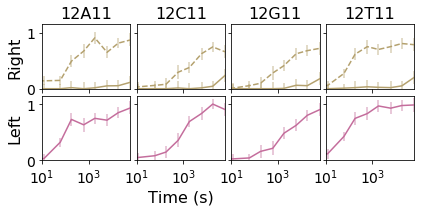

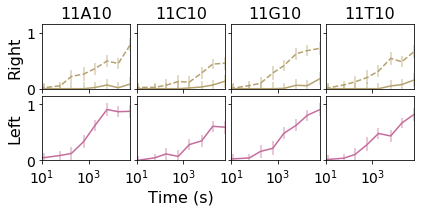

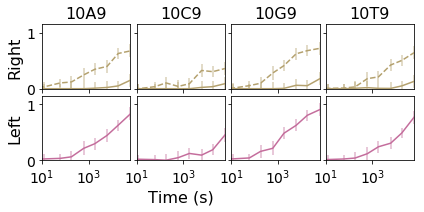

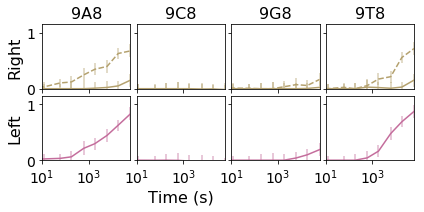

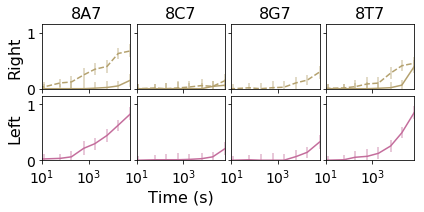

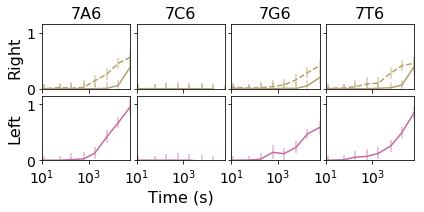

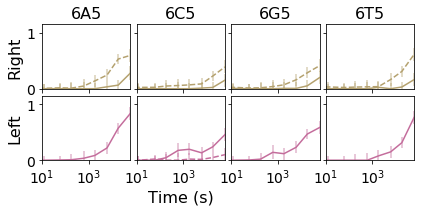

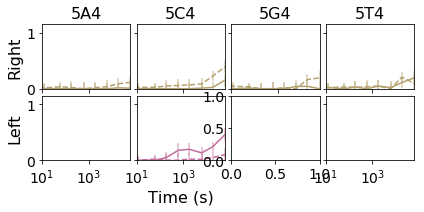

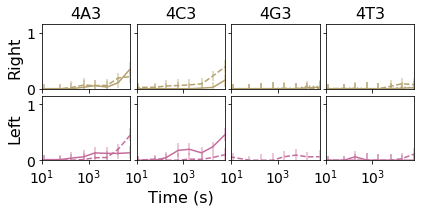

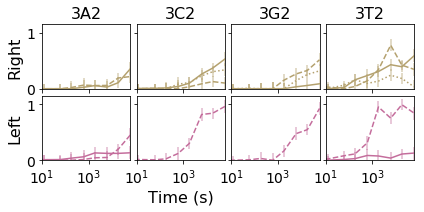

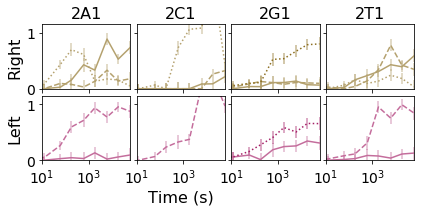

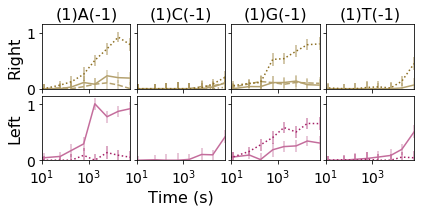

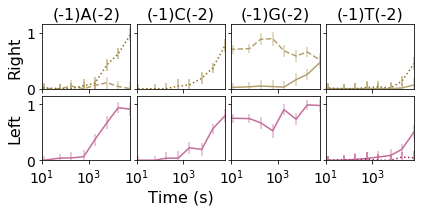

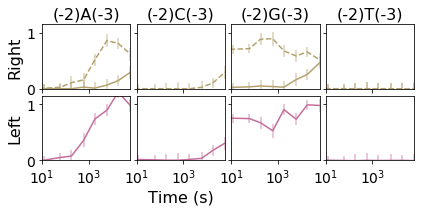

In [66]:
def plot_ins_pos_seqs(tab_dict, ins_pos):
    fig, axes = plt.subplots(2, 4, figsize=(5*4.0/3, 2.5), gridspec_kw=dict(wspace=0.07, hspace=0.11))
    for i, side in enumerate(['left', 'right']):
        i = 1-i
        for j, (ins_base, target_seq) in enumerate(ins_seqs_given_pos(ins_pos)):
            ax = axes[i, j]
            try:
                ys_given_site = build_single_ys_given_site(side, target_seq, tab_dict)
            except:
                continue
            for site, ys in sorted(ys_given_site.items()):
                for k, y in enumerate(ys):
                    assert k == 0, k
                    display_ins_pos = display_pos_given_abs(ins_pos)
                    label = label_from_display_pos(display_pos_given_pamtarg(site))
                    try:
                        color, ls = color_and_linestyle(side, display_pos_given_pamtarg(site))
                    except:
                        title = '{}{}{}'.format(display_pos_given_abs(ins_pos-1), ins_base, display_ins_pos)
                        print 'Failed', title, label
                        continue
                        
                    ax.errorbar(times, y, yerr=stds_maxes, color=color, alpha=0.5, zorder=-1, fmt='none')
                    ax.plot(times, y, color=color, linestyle=ls, label=label)
            ax.set_xscale('log')
            ax.set_xlim((10, times[-1]))
            ax.set_ylim((0, 1.15))
            ax.set_yticks((0, 1))
            #ax.legend(loc='upper left')
            if i == 0:
                display_ins_pos = display_pos_given_abs(ins_pos)
                if display_ins_pos >= 0:
                    title = '{}{}{}'.format(display_pos_given_abs(ins_pos-1), ins_base, display_ins_pos)
                else:
                    title = '({}){}({})'.format(display_pos_given_abs(ins_pos-1), ins_base, display_ins_pos)
                ax.set_title(title)
                ax.set_xticklabels([])
            if i == j == 1:
                ax.set_xlabel('Time (s)')
            if j == 0:
                ax.set_ylabel(side.capitalize())
            else:
                ax.set_yticklabels([])
    return fig, ax


for i in range(len(perfect_target)):
    ins_pos = i - 4
    if ins_pos >= 0:
        ins_pos += 1
    fig, ax = plot_ins_pos_seqs(prop_norm_pamtarg_3d_tab, i)
    fig.savefig(os.path.join(traces_fig_dir, '{}_ins_{}_cut_site_traces.png'.format(run_label, ins_pos)), dpi=300)
    fig.savefig(os.path.join(traces_fig_dir, '{}_ins_{}_cut_site_traces.eps'.format(run_label, ins_pos)))

# Single deletions

In [67]:
def del_seqs_given_pos(del_pos):
    yield perfect_target[:del_pos] + perfect_target[del_pos+1:]

/mnt/marble/hdd2/hawkjo/barcode_and_nucleaseq/src/nucleaseq/envnucleaseq/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice


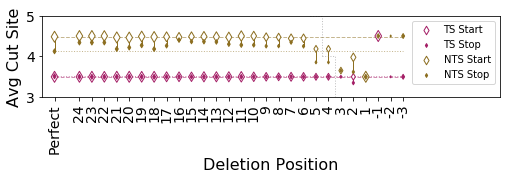

In [68]:
starts = {side: np.zeros((1, len(perfect_target))) for side in sides}
stops = {side: np.zeros((1, len(perfect_target))) for side in sides}
tab_dict = prop_norm_pamtarg_3d_tab
for del_pos in range(len(perfect_target)):
    for i, side in enumerate(['left', 'right']):
        for j, target_seq in enumerate(del_seqs_given_pos(del_pos)):
            start_avg_cut_pos, stop_avg_cut_pos = start_and_stop_avg_cut_pos(side, target_seq, tab_dict)
            starts[side][0, del_pos] = start_avg_cut_pos
            stops[side][0, del_pos] = stop_avg_cut_pos

log10_del_pos_cleavage_rate_avg = []
for del_pos in range(len(perfect_target)):
    all_cleave_rs = []
    for target_seq in del_seqs_given_pos(del_pos):
        all_cleave_rs.extend(cleavage_rates_given_target[target_seq])
    log10_del_pos_cleavage_rate_avg.append(np.log10(np.average(all_cleave_rs)))

fig, ax = plt.subplots(figsize=(8.2, 1.5))
label_given_side = {'left': 'TS', 'right': 'NTS'}
perfect_x = -2
ymin, ymax = float('inf'), float('-inf')
for i, side in enumerate(sides):
    offset = 0.3
    xticks = [perfect_x] + list(np.arange(len(perfect_target)))
    xticklabels = ['Perfect'] + [display_pos_given_abs(xx) for xx in xticks[1:]]
    ys = []
    for i, (mats, mark_color, label_suffix, perfect_avg_d, perfect_ls, mult_adjust) in enumerate(
        [(starts, 'w', 'Start', perfect_start_avg, '--', 1), 
         (stops, base_color_given_side[side], 'Stop', perfect_stop_avg, ':', 0.2)]
    ):
        M = mats[side]
        M[M == 0] = np.nan
        y = np.nanmean(M, axis=0)
        y = np.array([perfect_avg_d[side]] + list(y))
        y += display_offset
        ys.append(y)
        s = scatter_mult * mult_adjust * np.array([lipcr - np.log10(np.log(2)/times[-1])
                                                   for lipcr in log10_mm_pos_cleavage_rate_avg])
        x = [perfect_x] + list(np.arange(len(y)-1))
        label = '{} {}'.format(label_given_side[side], label_suffix)
        ax.scatter(x, y, s=s, facecolors=mark_color,
                   color=base_color_given_side[side], label=label, marker='d')
        ax.plot([xticks[0], xticks[-1]], [perfect_avg_d[side] + display_offset]*2,
                color=base_color_given_side[side], alpha=0.5, linestyle=perfect_ls, 
                linewidth=1, zorder=-1)
        ymin, ymax = min(min(y), ymin), max(max(y), ymax)
    for xx, yy1, yy2 in zip(x, *ys):
        ax.plot([xx]*2, [yy1, yy2], color=base_color_given_side[side], linewidth=1, zorder=-1)
yrange = ymax-ymin
ymin = int(math.floor(ymin-0.1*yrange))
ymax = int(math.ceil(ymax+0.1*yrange))
ylim = (ymin, ymax)
yint = next(i for i in range(1, 10) if (ymax - ymin)/float(i) < 5.0)
yticks = range(ymin, ymax+1, yint)
if pamtarg_pos < len(perfect_target)/2:
    for abs_pos in range(ylim[0] + pamtarg_pos - 1, len(perfect_target)):
        kw_args = dict(linestyle=':', color='grey', linewidth=1, zorder=-1, alpha=0.5)
        display_pos = display_pos_given_abs(abs_pos)
        ax.plot([abs_pos - 0.5]*2, [display_pos-1, display_pos], **kw_args)
        ax.plot([abs_pos - 0.5, abs_pos + 0.5], [display_pos, display_pos], **kw_args)
else:
    for abs_pos in range(int(abs_pos_given_display(ylim[1])), int(abs_pos_given_display(ylim[0])) + 1):
        kw_args = dict(linestyle=':', color='grey', linewidth=1, zorder=-1, alpha=0.5)
        display_pos = display_pos_given_abs(abs_pos)
        ax.plot([abs_pos - 0.5]*2, [display_pos, display_pos_given_abs(abs_pos-1)], **kw_args)
        ax.plot([abs_pos - 0.5, abs_pos + 0.5], [display_pos, display_pos], **kw_args)
ax.set_yticks(yticks)
ax.set_ylim(ylim)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=90)
ax.set_xlim([xticks[0]-1, len(perfect_target)*1.25])
ax.set_xlabel('Deletion Position')
ax.set_ylabel('Avg Cut Site')
ax.legend()
fig.savefig('figs/{}_del_avg_start_stop_cut_sites.png'.format(run_label), dpi=300)
fig.savefig('figs/{}_del_avg_start_stop_cut_sites.eps'.format(run_label))

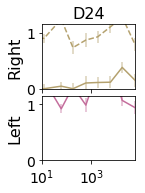

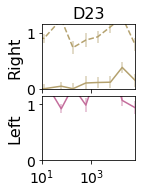

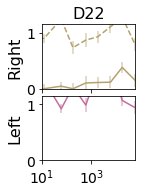

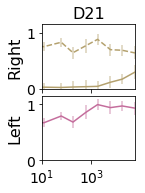

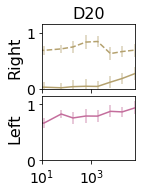

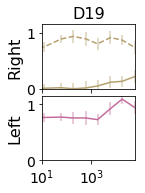

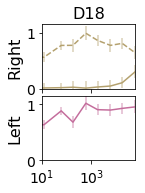

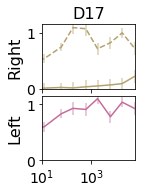

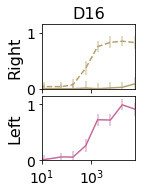

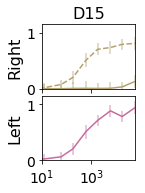

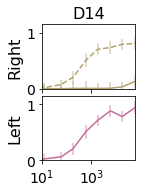

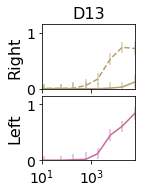

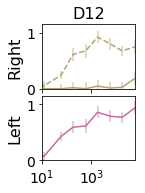

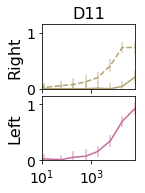

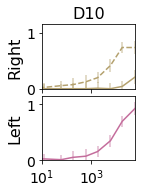

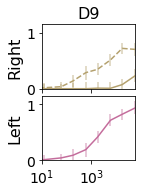

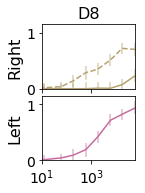

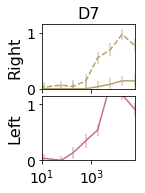

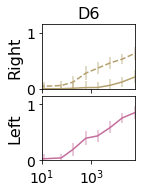

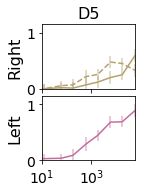

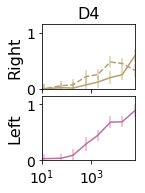

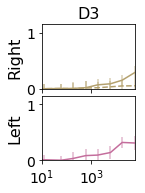

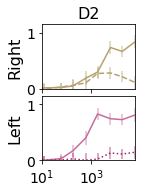

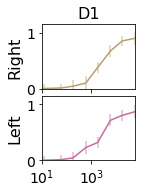

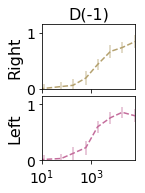

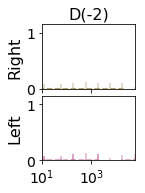

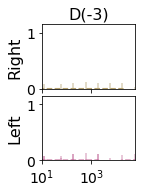

In [69]:
def plot_del_pos_seqs(tab_dict, del_pos):
    fig, axes = plt.subplots(2, 1, figsize=(5.0/3, 2.5), gridspec_kw=dict(wspace=0.07, hspace=0.11))
    for i, side in enumerate(['left', 'right']):
        i = 1-i
        for j, target_seq in enumerate(del_seqs_given_pos(del_pos)):
            ax = axes[i]
            ys_given_site = build_single_ys_given_site(side, target_seq, tab_dict)
            for site, ys in sorted(ys_given_site.items()):
                for k, y in enumerate(ys):
                    assert k == 0, k
                    display_del_pos = display_pos_given_abs(del_pos)
                    label = label_from_display_pos(display_pos_given_pamtarg(site))
                    try:
                        color, ls = color_and_linestyle(side, display_pos_given_pamtarg(site))
                    except:
                        title = 'D{}'.format(display_del_pos)
                        print 'Failed', title, label
                        continue
                        
                    ax.errorbar(times, y, yerr=stds_maxes, color=color, alpha=0.5, zorder=-1, fmt='none')
                    ax.plot(times, y, color=color, linestyle=ls, label=label)
            ax.set_xscale('log')
            ax.set_xlim((10, times[-1]))
            ax.set_ylim((0, 1.15))
            ax.set_yticks((0, 1))
            #ax.legend(loc='upper left')
            if i == 0:
                display_del_pos = display_pos_given_abs(del_pos)
                if display_del_pos >= 0:
                    title = 'D{}'.format(display_del_pos)
                else:
                    title = 'D({})'.format(display_del_pos)
                ax.set_title(title)
                ax.set_xticklabels([])
            if i == j == 1:
                ax.set_xlabel('Time (s)')
            if j == 0:
                ax.set_ylabel(side.capitalize())
            else:
                ax.set_yticklabels([])
    return fig, ax


for i in range(len(perfect_target)):
    del_pos = i - 4
    if del_pos >= 0:
        del_pos += 1
    fig, ax = plot_del_pos_seqs(prop_norm_pamtarg_3d_tab, i)
    fig.savefig(os.path.join(traces_fig_dir, '{}_del_{}_cut_site_traces.png'.format(run_label, del_pos)), dpi=300)
    fig.savefig(os.path.join(traces_fig_dir, '{}_del_{}_cut_site_traces.eps'.format(run_label, del_pos)))

# Output avg cut sites

For each oligo, outputs the avg cut site by time and side to `<run_label>_avg_cut_sites.txt`.

In [70]:
def avg_cut_pos_v_time(side, tseq_or_oligo, tab_dict):
    avg_cut_pos = []
    ys_given_site = build_single_ys_given_site(side, tseq_or_oligo, tab_dict)
    for time_idx in range(1, len(times)):
        vals_and_cut_pos = []
        for site, ys in sorted(ys_given_site.items()):
            for k, y in enumerate(ys):
                assert k == 0, k
                display_cut_pos = display_pos_given_pamtarg(site)
                vals_and_cut_pos.append((y[time_idx], display_cut_pos))
        val_sum = sum(tup[0] for tup in vals_and_cut_pos)
        if val_sum > cut_start_thresh:
            avg_cut_pos.append(sum(tup[0] * tup[1] for tup in vals_and_cut_pos) / val_sum)
        else:
            avg_cut_pos.append(None)
    return avg_cut_pos

In [71]:
fname = '{}_avg_cut_sites.txt'.format(run_label)
tab_dict = prop_norm_pamtarg_3d_tab

with open(fname, 'w') as out:
    oligo = oligo_container.oligos[0]
    out.write('\t'.join(oligo.pieces_names) + '\t')
    out.write('\t'.join(['{}_cutavgpos_{}'.format(side, t) for side in 'LR' for t in prot_samples[1:]]) + '\n')
    for oligo in sorted(oligo_container.oligos, key=lambda x: x._target):
        try:
            tab = tab_dict['left'].loc[oligo.sequence]
            tab = tab_dict['right'].loc[oligo.sequence]
        except:
            continue
        out.write('\t'.join(oligo.pieces) + '\t')
        output = []
        for side in ['left', 'right']:
            output.extend(avg_cut_pos_v_time(side, oligo, tab_dict))
        out.write('\t'.join(['{:.2f}'.format(xx) if xx is not None and np.isfinite(xx) else 'None' 
                             for xx in output]) + '\n')

/mnt/marble/hdd2/hawkjo/barcode_and_nucleaseq/src/nucleaseq/envnucleaseq/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in divide
/mnt/marble/hdd2/hawkjo/barcode_and_nucleaseq/src/nucleaseq/envnucleaseq/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in divide
/mnt/marble/hdd2/hawkjo/barcode_and_nucleaseq/src/nucleaseq/envnucleaseq/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/mnt/marble/hdd2/hawkjo/barcode_and_nucleaseq/src/nucleaseq/envnucleaseq/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars
